In [1]:
import matplotlib.pyplot as plt

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import math

# Core jax
import jax
# from jax.config import config
# from jax import Array, vmap

import jax.numpy as jnp
import jax.random as jr
import numpy as np
import equinox as eqx
# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'false'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

# or wherever your original class is actually imported from

##############################################################################
# Suppose these are your existing coordinate / interpolation funcs:
##############################################################################


def change_coords(x, y, nsamples, spacing=10):
    """
    Convert a real coordinate (x,y) into fractional indices for an nsamples x nsamples grid.
    spacing is a user-chosen scale factor controlling how quickly (x,y) shift the coords.
    """
    x_new = x / spacing
    y_new = y / spacing
    if nsamples % 2 == 1:
        coords = [((nsamples - 1) / 2) - y_new, ((nsamples - 1) / 2) + x_new]
    else:
        coords = [
            ((nsamples - 2) / 2) + 0.5 - y_new, 
            ((nsamples - 2) / 2) + 0.5 + x_new
        ]
    return coords

def weighted_sum_jax(x, y, grid, z_order):
    """
    Interpolates a 3D grid (nsamples, nsamples, nZernike) at coordinate (x,y) in the first 2 dims,
    returning the slice for polynomial index (z_order - 1).
    Under the hood, calls jax.scipy.ndimage.map_coordinates for linear interpolation.
    """
    from jax.scipy.ndimage import map_coordinates
    coords = change_coords(x, y, grid.shape[0])
    coords.append(z_order - 1)  # picking the 3rd dimension slice
    return map_coordinates(grid, coords, order=1)

In [2]:
# This was made using Connor's help - I think it's mostly a direct copy of code he already has in his repo.
phase_mask = np.load("/Users/angusrutherford/Desktop/dLuxToliman/new_diffractive_pupil.npy")

mask = dl.Optic(phase=phase_mask)

wavefront_npix = 2000 # 2000 # Wavefront number of pixels
aperture_diam = 0.125 # Diameter of aperture (m)
oversample = 1
coords = dlu.pixel_coords(wavefront_npix * oversample, aperture_diam)
secondary_diam = 0.032 # Diameter of secondary mirror (m)
spider_width = 0.002 # Spider width (m)
#psf_npixels = 256 #3600 # Number of pixels across one axis on detector
psf_npixels = 100
pixel_scale = 0.375 # Converting angle between binary source to angle on detector
primary = dlu.circle(coords, aperture_diam/2)
secondary = dlu.circle(coords, secondary_diam/2, invert=True)
angles = [0, 120, 240]
spiders = dlu.spider(coords, spider_width, angles)

aperture = dlu.combine([primary, secondary, spiders], oversample)

# Define the optical layers
layers = [("aperture", dl.layers.Optic(aperture, normalise=True)), ("phase_mask", mask)]

# Construct the optics object
# optics = dl.AngularOpticalSystem(wavefront_npix, aperture_diam, layers, psf_npixels, pixel_scale, oversample)
optics = dlT.TolimanOpticalSystem(
    wavefront_npix,
    psf_npixels,
    oversample,
    pixel_scale,
    mask=mask,
    radial_orders=[6]
    )

# det_pixsize = dlu.arcsec2rad(optics.psf_pixel_scale / optics.oversample)
# dither_offsets = 0.375 * jnp.array([[i, j] for i in [-2, -1, 0, 1, 2] for j in [-2, -1, 0, 1, 2]])

# psfs = []

# for offset in dither_offsets:
#     source = dlT.AlphaCen(
#     n_wavels=3,
#     separation=10.0,
#     position_angle=90,
#     x_position=offset[0],
#     y_position=offset[1],
#     log_flux=6.832,
#     contrast=3.37,
#     bandpass=(530, 640),
#     weights=None
#     )
#     instrument = dlT.Toliman(optics, source)

#     psf = instrument.model()
#     psfs.append(psf)

# Build a source
# source = dlT.AlphaCen(
#     n_wavels=3,
#     separation=10.0,
#     position_angle=90,
#     x_position=0,
#     y_position=0,
#     log_flux=6.832,
#     contrast=3.37,
#     bandpass=(530, 640),
#     weights=None
# )

# instrument = dlT.Toliman(optics, source)

# psf = instrument.model()

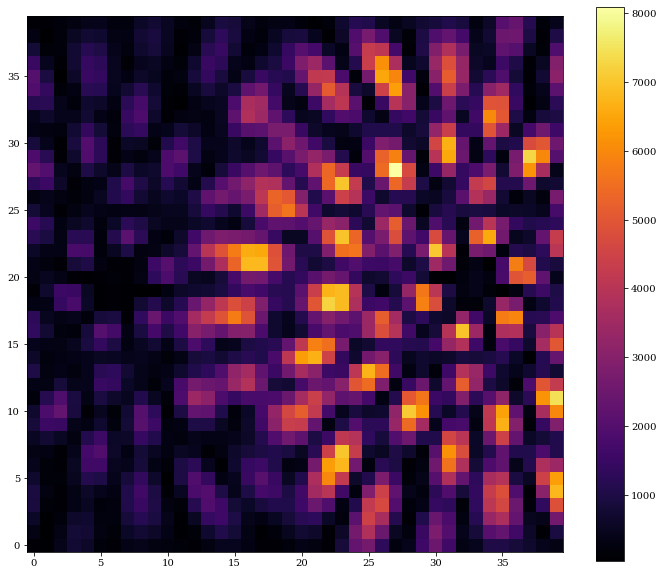

In [332]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure(figsize= (12, 10))
plt.imshow(psf[int(psf_npixels/2 - 20): int(psf_npixels/2 + 20), int(psf_npixels/2 - 20): int(psf_npixels/2 + 20)])
plt.colorbar()
plt.savefig("cropped_psf.png")
plt.show()
#plt.imshow(psf[10:20, 10:20])

# view_start = 100
# view_end = 156
# zoomed_psf = psf[view_start:view_end, view_start:view_end]

# # Recompute center **relative to the zoomed image**
# center = (view_end - view_start) // 2
# box_size = 20
# half = box_size // 2
# top_left = (center - half, center - half)

# fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(zoomed_psf)

# # Draw box within zoomed view
# rect = patches.Rectangle(
#     (top_left[1], top_left[0]),  # (col, row)
#     box_size, box_size,
#     linewidth=2,
#     edgecolor='red',
#     facecolor='none'
# )
# ax.add_patch(rect)
# plt.show()


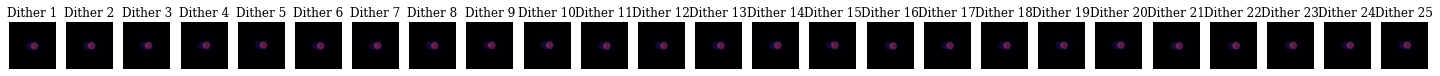

In [168]:
plt.figure(figsize=(20, 4))
for i, psf_d in enumerate(psfs):
    plt.subplot(1, len(psfs), i+1)
    plt.imshow(psf_d)
    plt.title(f"Dither {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [36]:
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates
import numpyro.distributions as dist
from tqdm import tqdm

def generate_distorted_grid(psf_npixels: int,
                            pixel_scale: float,
                            shift_mean_x: float = 0.0,
                            shift_mean_y: float = 0.0,
                            shift_std: float = 0.0,
                            pDistort: float = 1.0,                 
                            key: jax.random.PRNGKey = None,
                            noise_field_x: jnp.ndarray = None,
                            noise_field_y: jnp.ndarray = None):
    """
    Creates a distorted grid by shifting each pixel's (x, y) coordinate.

    Args:
      psf_npixels: Size of the PSF array (e.g. 256).
      pixel_scale: Arcsec per pixel.
      shift_mean_x, shift_mean_y: Mean shift (arcsec).
      shift_std: Std dev of random jitter (arcsec).
      pDistort: Fraction of pixels that actually get the random jitter [0..1].
      key: A JAX PRNGKey. Required if pDistort is between 0 and 1, because
           we need to sample a Bernoulli mask. If None, we assume either 
           pDistort=0 or 1, or you supply precomputed noise fields that you
           want to apply to all pixels.
      noise_field_x, noise_field_y: Fixed noise fields of shape 
           (psf_npixels, psf_npixels). If these are provided (and key=None),
           then the shifts will be exactly the same on every call.

    Returns:
      (distorted_grid_x, distorted_grid_y): 2D arrays of x- and y-coordinates
      in physical units (arcsec), with the desired pixel-level distortions.

    Raises:
      ValueError: If shift_std != 0 but neither a key nor noise fields are given.
                  Or if pDistort in (0,1) but no key is given.
    """

    # Create the base grid in arcseconds
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1) / 2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)  # "xy" indexing

    if shift_std != 0.0:
        # We need random offsets from Normal(0, shift_std).
        if key is not None:
            # Generate a random noise field
            noise_x = jax.random.normal(key, shape=(psf_npixels, psf_npixels))
            key, subkey = jax.random.split(key)
            noise_y = jax.random.normal(subkey, shape=(psf_npixels, psf_npixels))

            # Create a mask for partial distortion
            if pDistort == 1.0:
                mask = jnp.ones_like(noise_x)
            elif pDistort == 0.0:
                mask = jnp.zeros_like(noise_x)
            else:
                # pDistort in (0,1) => sample a Bernoulli mask
                key, subkey = jax.random.split(key)
                mask = jax.random.bernoulli(subkey, pDistort, shape=noise_x.shape)

        elif (noise_field_x is not None) and (noise_field_y is not None):
            # Use the fixed noise fields
            noise_x = noise_field_x
            noise_y = noise_field_y

            # If no key is given, we can only do pDistort=0 or 1.
            if pDistort == 1.0:
                mask = jnp.ones_like(noise_x)
            elif pDistort == 0.0:
                mask = jnp.zeros_like(noise_x)
            else:
                raise ValueError(
                    "pDistort is between 0 and 1, but no key was provided. "
                    "We can't randomly choose which pixels get distorted without a PRNG key. "
                    "If you want deterministic partial distortion, implement a custom mask."
                )

        else:
            # shift_std != 0 but we have no way to generate or supply random fields
            raise ValueError("When shift_std != 0, supply a key or noise_field arrays.")

        # Apply the random offsets scaled by mask
        shift_x_arr = shift_mean_x + shift_std * noise_x * mask
        shift_y_arr = shift_mean_y + shift_std * noise_y * mask

    else:
        # If shift_std=0, there's no random offset
        shift_x_arr = jnp.full((psf_npixels, psf_npixels), shift_mean_x)
        shift_y_arr = jnp.full((psf_npixels, psf_npixels), shift_mean_y)

    # By convention, positive shift_mean_y moves the PSF 'up' => subtract from Y
    distorted_grid_x = grid_x - shift_x_arr
    distorted_grid_y = grid_y - shift_y_arr

    return distorted_grid_x, distorted_grid_y

def physical_to_indices(grid_x: jnp.ndarray, grid_y: jnp.ndarray,
                        nsamples: int, pixel_scale: float) -> jnp.ndarray:
    center = (nsamples - 1) / 2.0
    # Here we assume: row = center - (y/pixel_scale) and col = center + (x/pixel_scale)
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf: jnp.ndarray,
                                 grid_x: jnp.ndarray,
                                 grid_y: jnp.ndarray,
                                 pixel_scale: float) -> jnp.ndarray:
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

def get_fixed_noise_fields(psf_npixels: int, seed: int = 123):
    key = jax.random.PRNGKey(seed)
    noise_field_x = jax.random.normal(key, shape=(psf_npixels, psf_npixels))
    key, subkey = jax.random.split(key)
    noise_field_y = jax.random.normal(subkey, shape=(psf_npixels, psf_npixels))
    return noise_field_x, noise_field_y

# --- Simple configurable MH Sampler ---
def fit_distortion(free_params: dict, fixed_params: dict, num_iters: int,
                   proposal_std: float, psf, observed_psf, psf_npixels: int,
                   pixel_scale: float, sigma: float, noise_field_x, noise_field_y, seed=0):
    """
    free_params: dictionary of free parameter initial guesses (e.g. {"shift_mean_y": 0.0})
    fixed_params: dictionary of fixed parameters (e.g. {"shift_mean_x": 2.0, "shift_std": 1.0})
    
    This function runs a basic Metropolis–Hastings sampler on the free parameters only.
    It prints and returns the posterior means for the free parameters.
    """
    # Create a sorted list of keys for free parameters.
    free_keys = sorted(free_params.keys())
    # Convert free_params dict to vector (in sorted order)
    init_vector = jnp.array([free_params[k] for k in free_keys])
    
    def combine_params(free_vector):
        combined = fixed_params.copy()
        for i, key in enumerate(free_keys):
            combined[key] = free_vector[i]
        return combined

    def log_prob_fn(free_vector):
        params = combine_params(free_vector)
        # Enforce nonnegative shift_std if it is one of the parameters.
        if "shift_std" in params and params["shift_std"] < 0:
            return -jnp.inf
        grid_x, grid_y = generate_distorted_grid(
            psf_npixels, pixel_scale,
            shift_mean_x=params.get("shift_mean_x", 0.0),
            shift_mean_y=params.get("shift_mean_y", 0.0),
            shift_std=params.get("shift_std", 0.0),
            key=None,
            noise_field_x=noise_field_x,
            noise_field_y=noise_field_y
        )
        predicted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        log_like = -0.5 * jnp.sum(((predicted_psf - observed_psf) ** 2) / (sigma ** 2))
        lp = log_like
        if "shift_mean_x" in params:
            lp += dist.Normal(0.0, 10.0).log_prob(params["shift_mean_x"])
        if "shift_mean_y" in params:
            lp += dist.Normal(0.0, 10.0).log_prob(params["shift_mean_y"])
        if "shift_std" in params:
            lp += dist.HalfNormal(10.0).log_prob(params["shift_std"])
        return lp

    key = jax.random.PRNGKey(seed)
    current = init_vector
    current_lp = log_prob_fn(current)
    samples = [current]
    for i in tqdm(range(num_iters), desc="MH Sampling"):
        key, subkey = jax.random.split(key)
        proposal = current + proposal_std * jax.random.normal(subkey, shape=current.shape)
        proposal_lp = log_prob_fn(proposal)
        key, subkey = jax.random.split(key)
        u = jax.random.uniform(subkey)
        if jnp.log(u) < (proposal_lp - current_lp):
            current = proposal
            current_lp = proposal_lp
        samples.append(current)
    samples = jnp.array(samples)
    posterior_mean = jnp.mean(samples, axis=0)
    result = {k: float(posterior_mean[i]) for i, k in enumerate(free_keys)}
    formatted_result = ", ".join(f"{k} = {v:.6f}" for k, v in sorted(result.items()))
    print("Posterior means:", formatted_result)
    return samples, result

psf_npixels = 256
pixel_scale = 0.375
sigma = 1
key = jax.random.PRNGKey(123)
pDistort = 1

# Ground truth parameters for observed PSF:
true_params = {"shift_mean_x": -0.5, "shift_mean_y": 0.5, "shift_std": 0.1}
noise_field_x, noise_field_y = get_fixed_noise_fields(psf_npixels, seed=123)
grid_x, grid_y = generate_distorted_grid(psf_npixels, pixel_scale,
                                          shift_mean_x=true_params["shift_mean_x"],
                                          shift_mean_y=true_params["shift_mean_y"],
                                          shift_std=true_params["shift_std"],
                                          key=key,
                                          pDistort=pDistort,
                                          noise_field_x=noise_field_x,
                                          noise_field_y=noise_field_y)
observed_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)


free_params = {"shift_std": 0, "shift_mean_x": 0, "shift_mean_y": 0}         # initial guess for free parameter(s)
fixed_params = {}
sample, result = fit_distortion(free_params, fixed_params, num_iters=10000, proposal_std=0.01,
                             psf=psf, observed_psf=observed_psf, psf_npixels=psf_npixels,
                             pixel_scale=pixel_scale, sigma=sigma,
                             noise_field_x=noise_field_x, noise_field_y=noise_field_y, seed=0)

MH Sampling: 100%|██████████| 10000/10000 [00:14<00:00, 672.75it/s]


Posterior means: shift_mean_x = -0.494600, shift_mean_y = 0.495071, shift_std = 0.098196


In [233]:
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates
import numpyro.distributions as dist
from tqdm import tqdm

def generate_linear_distorted_grid(psf_npixels: int,
                                pixel_scale: float,
                                cx_00: float, cx_10: float, cx_01: float,
                                cy_00: float, cy_10: float, cy_01: float):
    """
    Distort each pixel's coords by a linear polynomial in (x,y).
    
    shift_x = cx_00 + cx_10*x + cx_01*y
    shift_y = cy_00 + cy_10*x + cy_01*y
    Then the final coordinate is (x - shift_x, y - shift_y).
    """
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1) / 2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)

    shift_x = cx_00 + cx_10 * grid_x + cx_01 * grid_y
    shift_y = cy_00 + cy_10 * grid_x + cy_01 * grid_y

    distorted_grid_x = grid_x - shift_x
    distorted_grid_y = grid_y - shift_y
    return distorted_grid_x, distorted_grid_y

def generate_quadratic_distorted_grid(psf_npixels: int,
                                       pixel_scale: float,
                                       cx_00: float, cx_10: float, cx_01: float, 
                                       cx_20: float, cx_11: float, cx_02: float,
                                       cy_00: float, cy_10: float, cy_01: float,
                                       cy_20: float, cy_11: float, cy_02: float):
    """
    Distort each pixel's coords by a quadratic polynomial in (x,y).
    
    shift_x = cx_00 + cx_10*x + cx_01*y + cx_20*x^2 + cx_11*xy + cx_02*y^2
    shift_y = cy_00 + cy_10*x + cy_01*y + cy_20*x^2 + cy_11*xy + cy_02*y^2
    Then the final coordinate is (x - shift_x, y - shift_y).
    """
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1) / 2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)

    shift_x = (cx_00 + 
               cx_10 * grid_x + 
               cx_01 * grid_y + 
               cx_20 * grid_x**2 + 
               cx_11 * grid_x * grid_y + 
               cx_02 * grid_y**2)
    
    shift_y = (cy_00 + 
               cy_10 * grid_x + 
               cy_01 * grid_y + 
               cy_20 * grid_x**2 + 
               cy_11 * grid_x * grid_y + 
               cy_02 * grid_y**2)

    distorted_grid_x = grid_x - shift_x
    distorted_grid_y = grid_y - shift_y
    return distorted_grid_x, distorted_grid_y

def physical_to_indices(grid_x, grid_y, nsamples, pixel_scale):
    center = (nsamples - 1) / 2.0
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf, grid_x, grid_y, pixel_scale):
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

In [234]:
def fit_distortion_enhanced(free_params: dict, fixed_params: dict, num_iters: int,
                          proposal_std: float, psf, distorted_psf, psf_npixels: int,
                          pixel_scale: float, sigma: float, seed=0):
    free_keys = sorted(free_params.keys())
    init_vector = jnp.array([free_params[k] for k in free_keys])

    def combine_params(free_vector):
        combined = fixed_params.copy()
        for i, key in enumerate(free_keys):
            combined[key] = free_vector[i]
        return combined
    
    def log_prob_fn(free_vector):
        params = combine_params(free_vector)
        cx_00 = params["cx_00"]
        cx_10 = params["cx_10"]
        cx_01 = params["cx_01"]
        cy_00 = params["cy_00"]
        cy_10 = params["cy_10"]
        cy_01 = params["cy_01"]

        grid_x, grid_y = generate_linear_distorted_grid(
            psf_npixels, pixel_scale,
            cx_00, cx_10, cx_01,
            cy_00, cy_10, cy_01
        )

        predicted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        
        # Use a robust loss function to handle outliers
        residuals = predicted_psf - distorted_psf
        # Huber loss - less sensitive to outliers than squared error
        delta = 3.0  # Threshold for switching from squared to linear loss
        loss = jnp.where(
            jnp.abs(residuals) < delta,
            0.5 * residuals**2,
            delta * (jnp.abs(residuals) - 0.5 * delta)
        )
        log_like = -jnp.sum(loss) / (sigma**2)
        
        # Use weaker priors for larger distortion values
        lp = log_like
        for k in free_keys:
            # Wider prior that can accommodate larger values
            lp += dist.Normal(0.0, 2.0).log_prob(params[k])
        return lp

    # Use multiple starting points and pick the best one
    num_starts = 1
    best_samples = None
    best_final_lp = -jnp.inf
    
    for start in range(num_starts):
        print(f"Starting chain {start+1}/{num_starts}")
        
        # Random starting point with larger initialization range
        key, subkey = jax.random.split(jax.random.PRNGKey(seed + start))
        current = init_vector + 0.1 * jax.random.normal(subkey, shape=init_vector.shape)
        current_lp = log_prob_fn(current)
        
        samples = []
        acceptance_count = 0
        
        # Implement adaptive step size
        adapt_interval = 100
        target_accept_rate = 0.3
        current_proposal_std = proposal_std
        
        # Burn-in phase
        burn_in = int(num_iters * 0.3)  # 30% burn-in for better mixing
        
        for i in tqdm(range(num_iters + burn_in), desc=f"MH Sampling (Chain {start+1})"):
            # Propose new parameters
            key, subkey = jax.random.split(key)
            proposal = current + current_proposal_std * jax.random.normal(subkey, shape=current.shape)
            proposal_lp = log_prob_fn(proposal)
            
            # Calculate acceptance probability
            key, subkey = jax.random.split(key)
            u = jax.random.uniform(subkey)
            acceptance_ratio = jnp.exp(proposal_lp - current_lp)
            
            accepted = False
            if u < acceptance_ratio:  # Accept the proposal
                current = proposal
                current_lp = proposal_lp
                accepted = True
                acceptance_count += 1
            
            # Adaptive step size during burn-in
            if i < burn_in and (i+1) % adapt_interval == 0:
                accept_rate = acceptance_count / adapt_interval
                if accept_rate < target_accept_rate:
                    current_proposal_std *= 0.9  # Decrease step size
                else:
                    current_proposal_std *= 1.1  # Increase step size
                acceptance_count = 0
            
            # Only save samples after burn-in, and thin the chain
            if i >= burn_in and i % 10 == 0:  # Save every 10th sample
                samples.append(current)
        
        samples = jnp.array(samples)
        
        # Keep the chain with the best final log probability
        if current_lp > best_final_lp:
            best_final_lp = current_lp
            best_samples = samples
    
    # Use the best chain for inference
    samples = best_samples
    posterior_mean = jnp.mean(samples, axis=0)
    result = {k: float(posterior_mean[i]) for i, k in enumerate(free_keys)}
    formatted_result = ", ".join(f"{k} = {v:.6f}" for k, v in sorted(result.items()))
    print("Posterior means:", formatted_result)
    
    # Print true values for comparison
    true_values = {}
    for k in free_keys:
        if k in fixed_params:
            true_values[k] = fixed_params[k]
        elif k in true_params:  # Assuming true_params is in the global scope
            true_values[k] = true_params[k]
        else:
            true_values[k] = "unknown"
    
    true_formatted = ", ".join(f"{k} = {v}" for k, v in sorted(true_values.items()))
    print("True values:", true_formatted)
    
    return samples, result

In [235]:
#Define the true parameters with larger distortion
true_params = {
    "cx_00": 0.0357, 
    "cx_10": 0.0991,   # Larger distortion 
    "cx_01": -0.001,
    "cy_00": 0.05, 
    "cy_10": -0.193,  # Larger negative distortion
    "cy_01": 0.085,
}



#Generate distorted PSF using these true parameters
grid_x, grid_y = generate_linear_distorted_grid(
    psf_npixels, pixel_scale,
    cx_00=true_params["cx_00"], cx_10=true_params["cx_10"], cx_01=true_params["cx_01"],
    cy_00=true_params["cy_00"], cy_10=true_params["cy_10"], cy_01=true_params["cy_01"]
)

distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)

# Initialize with zeros (or small random values)
free_params = {
    "cx_00": 0.0,
    "cx_10": 0.0,
    "cx_01": 0.0,
    "cy_00": 0.0,
    "cy_10": 0.0,
    "cy_01": 0.0,
}

fixed_params = {}

# Run the enhanced fitting algorithm
samples, result = fit_distortion_enhanced(
    free_params, fixed_params, 
    num_iters=25000,  # More iterations for better convergence
    proposal_std=0.1,  # Larger initial proposal size
    psf=psf, 
    distorted_psf=distorted_psf, 
    psf_npixels=psf_npixels,
    pixel_scale=pixel_scale, 
    sigma=1.0,  # Try different noise levels if needed
    seed=45
)

# Compare with true values
for k in true_params:
    print(f"{k}: True={true_params[k]:.6f}, Estimated={result.get(k, 'N/A')}")

Starting chain 1/1


MH Sampling (Chain 1): 100%|██████████| 32500/32500 [02:10<00:00, 248.48it/s]


Posterior means: cx_00 = 0.035720, cx_01 = -0.000996, cx_10 = 0.099098, cy_00 = 0.049966, cy_01 = 0.084998, cy_10 = -0.192996
True values: cx_00 = 0.0357, cx_01 = -0.001, cx_10 = 0.0991, cy_00 = 0.05, cy_01 = 0.085, cy_10 = -0.193
cx_00: True=0.035700, Estimated=0.03572044149041176
cx_10: True=0.099100, Estimated=0.09909842908382416
cx_01: True=-0.001000, Estimated=-0.0009958093287423253
cy_00: True=0.050000, Estimated=0.049966465681791306
cy_10: True=-0.193000, Estimated=-0.19299645721912384
cy_01: True=0.085000, Estimated=0.0849984735250473


In [193]:
def fit_distortion_enhanced(free_params: dict, fixed_params: dict, num_iters: int,
                          proposal_std: float, psf, distorted_psf, psf_npixels: int,
                          pixel_scale: float, sigma: float, seed=0):
    free_keys = sorted(free_params.keys())
    init_vector = jnp.array([free_params[k] for k in free_keys])

    def combine_params(free_vector):
        combined = fixed_params.copy()
        for i, key in enumerate(free_keys):
            combined[key] = free_vector[i]
        return combined
    
    def log_prob_fn(free_vector):
        params = combine_params(free_vector)

        grid_x, grid_y = generate_quadratic_distorted_grid(
        psf_npixels, pixel_scale,
        cx_00=params["cx_00"], cx_10=params["cx_10"], cx_01=params["cx_01"],
        cx_20=params["cx_20"], cx_11=params["cx_11"], cx_02=params["cx_02"],
        cy_00=params["cy_00"], cy_10=params["cy_10"], cy_01=params["cy_01"],
        cy_20=params["cy_20"], cy_11=params["cy_11"], cy_02=params["cy_02"]
    )

        predicted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        
        # Use a robust loss function to handle outliers
        residuals = predicted_psf - distorted_psf
        # Huber loss - less sensitive to outliers than squared error
        delta = 0.001  # Threshold for switching from squared to linear loss
        loss = jnp.where(
            jnp.abs(residuals) < delta,
            0.5 * residuals**2,
            delta * (jnp.abs(residuals) - 0.5 * delta)
        )
        log_like = -jnp.sum(loss) / (sigma**2)
        
        # Use weaker priors for larger distortion values
        lp = log_like
        for k in free_keys:
            # Wider prior that can accommodate larger values
            lp += dist.Normal(0.0, 1e-5).log_prob(params[k])
        return lp

    # Use multiple starting points and pick the best one
    num_starts = 5
    best_samples = None
    best_final_lp = -jnp.inf
    
    for start in range(num_starts):
        print(f"Starting chain {start+1}/{num_starts}")
        
        # Random starting point with larger initialization range
        key, subkey = jax.random.split(jax.random.PRNGKey(seed + start))
        current = init_vector + 0.1 * jax.random.normal(subkey, shape=init_vector.shape)
        current_lp = log_prob_fn(current)
        
        samples = []
        acceptance_count = 0
        
        # Implement adaptive step size
        adapt_interval = 100
        target_accept_rate = 0.3
        current_proposal_std = proposal_std
        
        # Burn-in phase
        burn_in = int(num_iters * 0.3)  # 30% burn-in for better mixing
        
        for i in tqdm(range(num_iters + burn_in), desc=f"MH Sampling (Chain {start+1})"):
            # Propose new parameters
            key, subkey = jax.random.split(key)
            proposal = current + current_proposal_std * jax.random.normal(subkey, shape=current.shape)
            proposal_lp = log_prob_fn(proposal)
            
            # Calculate acceptance probability
            key, subkey = jax.random.split(key)
            u = jax.random.uniform(subkey)
            acceptance_ratio = jnp.exp(proposal_lp - current_lp)
            
            accepted = False
            if u < acceptance_ratio:  # Accept the proposal
                current = proposal
                current_lp = proposal_lp
                accepted = True
                acceptance_count += 1
            
            # Adaptive step size during burn-in
            if i < burn_in and (i+1) % adapt_interval == 0:
                accept_rate = acceptance_count / adapt_interval
                if accept_rate < target_accept_rate:
                    current_proposal_std *= 0.9  # Decrease step size
                else:
                    current_proposal_std *= 1.1  # Increase step size
                acceptance_count = 0
            
            # Only save samples after burn-in, and thin the chain
            if i >= burn_in and i % 10 == 0:  # Save every 10th sample
                samples.append(current)
        
        samples = jnp.array(samples)
        
        # Keep the chain with the best final log probability
        if current_lp > best_final_lp:
            best_final_lp = current_lp
            best_samples = samples
    
    # Use the best chain for inference
    samples = best_samples
    posterior_mean = jnp.mean(samples, axis=0)
    result = {k: float(posterior_mean[i]) for i, k in enumerate(free_keys)}
    formatted_result = ", ".join(f"{k} = {v:.6f}" for k, v in sorted(result.items()))
    print("Posterior means:", formatted_result)
    
    # Print true values for comparison
    true_values = {}
    for k in free_keys:
        if k in fixed_params:
            true_values[k] = fixed_params[k]
        elif k in true_params:  # Assuming true_params is in the global scope
            true_values[k] = true_params[k]
        else:
            true_values[k] = "unknown"
    
    true_formatted = ", ".join(f"{k} = {v}" for k, v in sorted(true_values.items()))
    print("True values:", true_formatted)
    
    return samples, result

In [ ]:
true_params = {
    "cx_00": -1.766e-5,
    "cx_10": 4.861e-5,
    "cx_01": -9.992e-6,
    "cx_20": 3.439e-5,
    "cx_11": 1.225e-3,
    "cx_02": -8.477e-5,
    "cy_00": 6.1234e-4,
    "cy_10": 2.1e-5,
    "cy_01": -1.57e-5,
    "cy_20": 0.419e-5,
    "cy_11": -5.1158e-7,
    "cy_02": -2.222e-5,
}


grid_x, grid_y = generate_quadratic_distorted_grid(
    psf_npixels, pixel_scale,
    cx_00=true_params["cx_00"], cx_10=true_params["cx_10"], cx_01=true_params["cx_01"],
    cx_20=true_params["cx_20"], cx_11=true_params["cx_11"], cx_02=true_params["cx_02"],
    cy_00=true_params["cy_00"], cy_10=true_params["cy_10"], cy_01=true_params["cy_01"],
    cy_20=true_params["cy_20"], cy_11=true_params["cy_11"], cy_02=true_params["cy_02"]
)

distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)

free_params = {
    "cx_00": 0.0,
    "cx_10": 0.0,
    "cx_01": 0.0,
    "cx_20": 0.0,
    "cx_11": 0.0,
    "cx_02": 0.0,
    "cy_00": 0.0,
    "cy_10": 0.0,
    "cy_01": 0.0,
    "cy_20": 0.0,
    "cy_11": 0.0,
    "cy_02": 0.0
}

fixed_params = {}

# Run the enhanced fitting algorithm
samples, result = fit_distortion_enhanced(
    free_params, fixed_params, 
    num_iters=30000,  # More iterations for better convergence
    proposal_std=0.001,  # Larger initial proposal size
    psf=psf, 
    distorted_psf=distorted_psf, 
    psf_npixels=psf_npixels,
    pixel_scale=pixel_scale, 
    sigma=0.1,  # Try different noise levels if needed
    seed=45
)

# Compare with true values
for k in true_params:
    print(f"{k}: True={true_params[k]:.6f}, Estimated={result.get(k, 'N/A')}")

Starting chain 1/5


MH Sampling (Chain 1): 100%|██████████| 39000/39000 [01:53<00:00, 345.01it/s]


Starting chain 2/5


MH Sampling (Chain 2): 100%|██████████| 39000/39000 [01:52<00:00, 346.48it/s]


Starting chain 3/5


MH Sampling (Chain 3): 100%|██████████| 39000/39000 [01:51<00:00, 348.45it/s]


Starting chain 4/5


MH Sampling (Chain 4): 100%|██████████| 39000/39000 [01:51<00:00, 348.47it/s]


Starting chain 5/5


MH Sampling (Chain 5): 100%|██████████| 39000/39000 [01:49<00:00, 354.59it/s]


Posterior means: cx_00 = -0.000010, cx_01 = -0.000020, cx_02 = 0.000070, cx_10 = 0.000040, cx_11 = 0.000010, cx_20 = 0.000034, cy_00 = 0.000034, cy_01 = 0.000020, cy_02 = -0.000022, cy_10 = 0.000021, cy_11 = -0.000051, cy_20 = 0.000004
True values: cx_00 = -1e-05, cx_01 = -2e-05, cx_02 = 7e-05, cx_10 = 4e-05, cx_11 = 1e-05, cx_20 = 3.4e-05, cy_00 = 6e-05, cy_01 = 1.7e-05, cy_02 = -2.2e-05, cy_10 = 2e-05, cy_11 = -5.1e-05, cy_20 = 4e-06
cx_00: True=-0.000010, Estimated=-9.817724276217632e-06
cx_10: True=0.000040, Estimated=3.991055564256385e-05
cx_01: True=-0.000020, Estimated=-2.0116212908760644e-05
cx_20: True=0.000034, Estimated=3.40158621838782e-05
cx_11: True=0.000010, Estimated=9.997310371545609e-06
cx_02: True=0.000070, Estimated=6.998408935032785e-05
cy_00: True=0.000060, Estimated=3.419651693548076e-05
cy_10: True=0.000020, Estimated=2.0759996914421208e-05
cy_01: True=0.000017, Estimated=2.01953444047831e-05
cy_20: True=0.000004, Estimated=4.120895027881488e-06
cy_11: True=-0.0

Array(296.00195, dtype=float32)

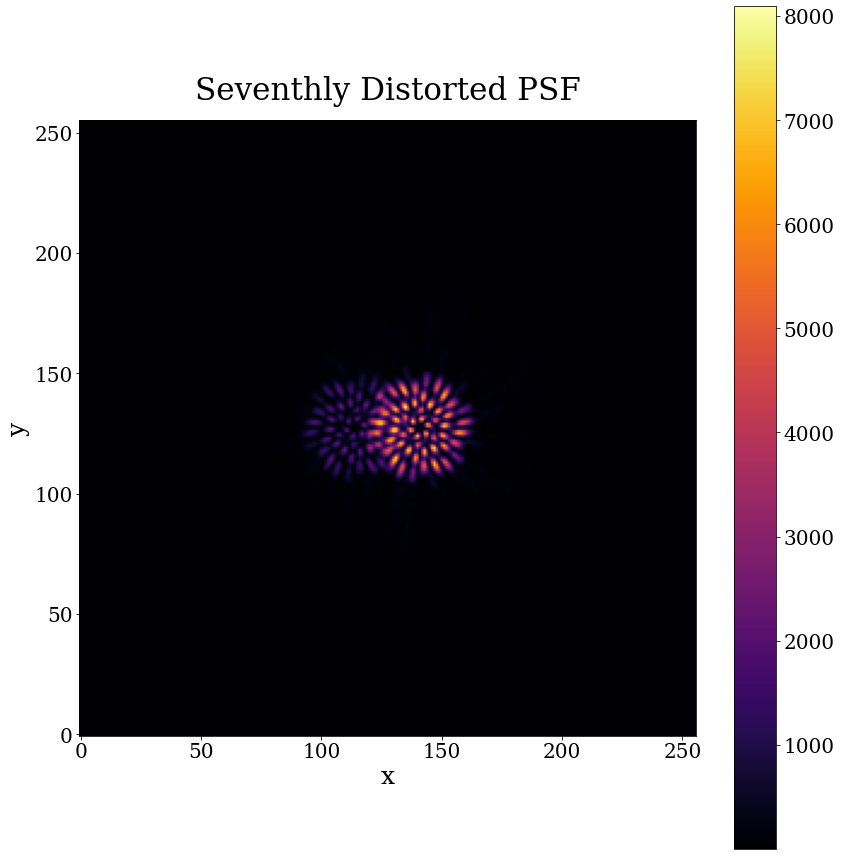

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
# im = ax.imshow(distorted_psf[78:178, 78:178])
im = ax.imshow(distorted_psf)
ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)
ax.set_title("Seventhly Distorted PSF", fontsize=31, pad = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
#plt.savefig("seventh_order_distorted_psf.png")
#plt.show()


# distorted_psf[76, 89]
# grid_y[76, 89]
np.max(distorted_psf - psf)

In [220]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
from tqdm import tqdm

def generate_quadratic_distorted_grid(psf_npixels, pixel_scale,
                                      cx_00, cx_10, cx_01,
                                      cx_20, cx_11, cx_02,
                                      cy_00, cy_10, cy_01,
                                      cy_20, cy_11, cy_02):
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1)/2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)
    
    shift_x = (cx_00 + cx_10*grid_x + cx_01*grid_y +
               cx_20*grid_x**2 + cx_11*grid_x*grid_y + cx_02*grid_y**2)
    shift_y = (cy_00 + cy_10*grid_x + cy_01*grid_y +
               cy_20*grid_x**2 + cy_11*grid_x*grid_y + cy_02*grid_y**2)
    
    distorted_grid_x = grid_x - shift_x
    distorted_grid_y = grid_y - shift_y
    return distorted_grid_x, distorted_grid_y

def physical_to_indices(grid_x, grid_y, nsamples, pixel_scale):
    center = (nsamples - 1)/2
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf, grid_x, grid_y, pixel_scale):
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

def build_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale):
    def loss_fn(params_vector):
        cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, \
        cy_00, cy_10, cy_01, cy_20, cy_11, cy_02 = params_vector

        grid_x, grid_y = generate_quadratic_distorted_grid(
            psf_npixels, pixel_scale,
            cx_00, cx_10, cx_01, cx_20, cx_11, cx_02,
            cy_00, cy_10, cy_01, cy_20, cy_11, cy_02
        )
        predicted = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        residuals = predicted - distorted_psf
        sse = jnp.sum(residuals**2)
        return sse
    return loss_fn

def fit_quadratic_with_adagrad(psf, distorted_psf,
                                psf_npixels, pixel_scale,
                                learning_rate=1e-3,
                                num_steps=5000,
                                epsilon=1e-8):
    # Initialize all parameters to zero
    init_params = jnp.zeros(12)
    
    loss_fn = build_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale)
    grad_fn = jax.grad(loss_fn)
    
    params = init_params
    grad_sum_squares = jnp.zeros_like(params)
    
    for i in tqdm(range(num_steps)):
        g = grad_fn(params)
        grad_sum_squares += g**2
        adaptive_lr = learning_rate / (jnp.sqrt(grad_sum_squares + epsilon))
        params = params - adaptive_lr * g
        
        if i % 500 == 0:
            print(f"Step {i}, Loss = {float(loss_fn(params))}")
    
    final_loss = float(loss_fn(params))
    return params, final_loss


true_params = {
    "cx_00": -1.766e-5,
    "cx_10": 4.861e-5,
    "cx_01": -9.992e-6,
    "cx_20": 3.439e-5,
    "cx_11": 1.225e-3,
    "cx_02": -8.477e-5,
    "cy_00": 6.1234e-4,
    "cy_10": 2.1e-5,
    "cy_01": -1.57e-5,
    "cy_20": 0.419e-5,
    "cy_11": -5.1158e-7,
    "cy_02": -2.222e-5,
}


grid_x, grid_y = generate_quadratic_distorted_grid(
    psf_npixels, pixel_scale,
    cx_00=true_params["cx_00"], cx_10=true_params["cx_10"], cx_01=true_params["cx_01"],
    cx_20=true_params["cx_20"], cx_11=true_params["cx_11"], cx_02=true_params["cx_02"],
    cy_00=true_params["cy_00"], cy_10=true_params["cy_10"], cy_01=true_params["cy_01"],
    cy_20=true_params["cy_20"], cy_11=true_params["cy_11"], cy_02=true_params["cy_02"]
)

distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
# Usage
best_params, final_loss = fit_quadratic_with_adagrad(
    psf, distorted_psf, psf_npixels, pixel_scale
)

  0%|          | 12/5000 [00:00<01:31, 54.44it/s]

Step 0, Loss = 259318240.0


 10%|█         | 511/5000 [00:08<01:09, 64.76it/s]

Step 500, Loss = 4.886281490325928


 20%|██        | 1008/5000 [00:15<01:00, 66.32it/s]

Step 1000, Loss = 0.05533292889595032


 30%|███       | 1512/5000 [00:23<00:54, 64.55it/s]

Step 1500, Loss = 0.0006853670347481966


 40%|████      | 2009/5000 [00:31<00:49, 59.86it/s]

Step 2000, Loss = 0.0001281659642700106


 50%|█████     | 2511/5000 [00:39<00:39, 62.44it/s]

Step 2500, Loss = 0.0002916195953730494


 60%|██████    | 3008/5000 [00:47<00:31, 62.78it/s]

Step 3000, Loss = 3.947087316191755e-05


 70%|███████   | 3512/5000 [00:55<00:24, 59.93it/s]

Step 3500, Loss = 1.9773036910919473e-05


 80%|████████  | 4012/5000 [01:03<00:14, 66.18it/s]

Step 4000, Loss = 4.46108533651568e-05


 90%|█████████ | 4509/5000 [01:11<00:07, 62.12it/s]

Step 4500, Loss = 0.00013580129598267376


100%|██████████| 5000/5000 [01:19<00:00, 62.97it/s]


In [ ]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
from tqdm import tqdm

##############################################################################
# 1) Generate Cubic Distorted Grid
##############################################################################
def generate_cubic_distorted_grid(psf_npixels, pixel_scale,
                                  cx_00, cx_10, cx_01, cx_20, cx_11, cx_02,
                                  cx_30, cx_21, cx_12, cx_03,
                                  cy_00, cy_10, cy_01, cy_20, cy_11, cy_02,
                                  cy_30, cy_21, cy_12, cy_03):
    """
    Returns (distorted_grid_x, distorted_grid_y) for a cubic polynomial in x,y.
    shift_x = cx_00 + cx_10*x + cx_01*y + cx_20*x^2 + cx_11*x*y + cx_02*y^2
                              + cx_30*x^3 + cx_21*x^2*y + cx_12*x*y^2 + cx_03*y^3
    shift_y = cy_00 + cy_10*x + cy_01*y + cy_20*x^2 + cy_11*x*y + cy_02*y^2
                              + cy_30*x^3 + cy_21*x^2*y + cy_12*x*y^2 + cy_03*y^3
    We then do x_distorted = x - shift_x, y_distorted = y - shift_y.
    """

    # Create arcsecond coords for each pixel
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1)/2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)

    # Evaluate X-shift for each pixel
    shift_x = (cx_00 
               + cx_10*grid_x + cx_01*grid_y
               + cx_20*(grid_x**2) + cx_11*(grid_x*grid_y) + cx_02*(grid_y**2)
               + cx_30*(grid_x**3) + cx_21*(grid_x**2)*grid_y 
               + cx_12*grid_x*(grid_y**2) + cx_03*(grid_y**3))

    # Evaluate Y-shift for each pixel
    shift_y = (cy_00 
               + cy_10*grid_x + cy_01*grid_y
               + cy_20*(grid_x**2) + cy_11*(grid_x*grid_y) + cy_02*(grid_y**2)
               + cy_30*(grid_x**3) + cy_21*(grid_x**2)*grid_y
               + cy_12*grid_x*(grid_y**2) + cy_03*(grid_y**3))

    # Distort the grid
    distorted_grid_x = grid_x - shift_x
    distorted_grid_y = grid_y - shift_y

    return distorted_grid_x, distorted_grid_y

##############################################################################
# 2) Utility: from physical coords -> indices -> sample with map_coordinates
##############################################################################
def physical_to_indices(grid_x, grid_y, nsamples, pixel_scale):
    center = (nsamples - 1)/2
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf, grid_x, grid_y, pixel_scale):
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

##############################################################################
# 3) Build a loss function for the cubic model
##############################################################################
def build_cubic_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale):
    """
    Returns a function 'loss_fn(params_vector) -> scalar SSE'
    where 'params_vector' is length 20:
      [cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
       cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03]
    """
    def loss_fn(params_vector):
        (cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
         cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03) = params_vector

        # Generate the distorted grid using cubic expansions
        grid_x, grid_y = generate_cubic_distorted_grid(
            psf_npixels, pixel_scale,
            cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
            cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03
        )

        # Warp the ideal PSF
        predicted = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        # Compare to observed: sum of squared differences
        residuals = predicted - distorted_psf
        sse = jnp.sum(residuals**2)
        return sse

    return loss_fn

##############################################################################
# 4) Fit with Adagrad, using 20 parameters for the cubic polynomial
##############################################################################
def fit_cubic_with_adagrad(psf, distorted_psf,
                           psf_npixels, pixel_scale,
                           learning_rate=1e-3,
                           num_steps=5000,
                           epsilon=1e-8):
    """
    Gradient-based approach (Adagrad) to fit 20 cubic polynomial parameters:
      [cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
       cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03]
    """
    # 1) Initialize the 20 parameters to zero
    init_params = jnp.zeros(20)

    # 2) Build the loss function & gradient
    loss_fn = build_cubic_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale)
    grad_fn = jax.grad(loss_fn)

    # 3) Prepare Adagrad accumulators
    params = init_params
    grad_sum_squares = jnp.zeros_like(params)

    # 4) Main loop
    for i in tqdm(range(num_steps)):
        g = grad_fn(params)  # compute gradient wrt the 20 parameters
        grad_sum_squares += g**2
        adaptive_lr = learning_rate / (jnp.sqrt(grad_sum_squares + epsilon))
        params = params - adaptive_lr * g

        # Optional progress print
        if i % 500 == 0:
            current_loss = float(loss_fn(params))
            print(f"Step {i}, Loss = {current_loss}")

    final_loss = float(loss_fn(params))
    return params, final_loss

##############################################################################
# 5) Example usage
##############################################################################
# Suppose you already have:
#   psf: your 'ideal' PSF of shape (psf_npixels, psf_npixels)
#   psf_npixels, pixel_scale
# We'll define randomish "true" cubic parameters for demonstration:

true_cubic_params = {
    "cx_00":  0.00023,   "cx_10": -0.00012,  "cx_01":  0.0008,
    "cx_20":  0.0002,   "cx_11":  0.0005, "cx_02":  0.0009,
    "cx_30": -0.0001,  "cx_21":  0.0006, "cx_12": -0.0004, "cx_03":  0.0002,

    "cy_00": -0.00015,   "cy_10":  0.00021,  "cy_01":  0.0003,
    "cy_20":  0.0001,   "cy_11": -0.0002, "cy_02":  0.00015,
    "cy_30":  0.0002,  "cy_21": -0.0007, "cy_12":  0.0003, "cy_03": -0.0001
}

# Convert dict to the 20D vector in the correct order:
true_vector = jnp.array([
    true_cubic_params["cx_00"], true_cubic_params["cx_10"], true_cubic_params["cx_01"],
    true_cubic_params["cx_20"], true_cubic_params["cx_11"], true_cubic_params["cx_02"],
    true_cubic_params["cx_30"], true_cubic_params["cx_21"], true_cubic_params["cx_12"], true_cubic_params["cx_03"],

    true_cubic_params["cy_00"], true_cubic_params["cy_10"], true_cubic_params["cy_01"],
    true_cubic_params["cy_20"], true_cubic_params["cy_11"], true_cubic_params["cy_02"],
    true_cubic_params["cy_30"], true_cubic_params["cy_21"], true_cubic_params["cy_12"], true_cubic_params["cy_03"]
])

# Distort the grid
grid_x, grid_y = generate_cubic_distorted_grid(
    psf_npixels, pixel_scale,
    *true_vector[:10],   # first 10 are cx-coeffs
    *true_vector[10:]    # last 10 are cy-coeffs
)

# Build a synthetic "distorted_psf"
distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)

# Now run the cubic fitter
best_params, final_loss = fit_cubic_with_adagrad(
    psf, distorted_psf,
    psf_npixels=psf_npixels,
    pixel_scale=pixel_scale,
    learning_rate=1e-4,
    num_steps=10000
)

print("\nFinal SSE:", final_loss)
print("Best-fit params:", best_params)


  0%|          | 10/10000 [00:00<03:41, 45.05it/s]

Step 0, Loss = 652491620352.0


  5%|▌         | 506/10000 [00:10<04:04, 38.86it/s]

Step 500, Loss = 6710295040.0


 10%|█         | 1008/10000 [00:20<02:53, 51.96it/s]

Step 1000, Loss = 6102681600.0


 15%|█▌        | 1506/10000 [00:30<02:47, 50.69it/s]

Step 1500, Loss = 5967728128.0


 20%|██        | 2010/10000 [00:39<02:33, 51.94it/s]

Step 2000, Loss = 5876895232.0


 23%|██▎       | 2310/10000 [00:45<02:32, 50.49it/s]


KeyboardInterrupt: 

In [25]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
from tqdm import tqdm

##############################################################################
# 1) Generate Cubic Distorted Grid
##############################################################################
def generate_cubic_distorted_grid(psf_npixels, pixel_scale,
                                  cx_00, cx_10, cx_01, cx_20, cx_11, cx_02,
                                  cx_30, cx_21, cx_12, cx_03,
                                  cy_00, cy_10, cy_01, cy_20, cy_11, cy_02,
                                  cy_30, cy_21, cy_12, cy_03):
    """
    Returns (distorted_grid_x, distorted_grid_y) for a cubic polynomial in x,y.
    shift_x = cx_00 + cx_10*x + cx_01*y + cx_20*x^2 + cx_11*x*y + cx_02*y^2
                              + cx_30*x^3 + cx_21*x^2*y + cx_12*x*y^2 + cx_03*y^3
    shift_y = cy_00 + cy_10*x + cy_01*y + cy_20*x^2 + cy_11*x*y + cy_02*y^2
                              + cy_30*x^3 + cy_21*x^2*y + cy_12*x*y^2 + cy_03*y^3
    We then do x_distorted = x - shift_x, y_distorted = y - shift_y.
    """

    # Create arcsecond coords for each pixel
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1)/2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)

    # Evaluate X-shift for each pixel
    shift_x = (cx_00 
               + cx_10*grid_x + cx_01*grid_y
               + cx_20*(grid_x**2) + cx_11*(grid_x*grid_y) + cx_02*(grid_y**2)
               + cx_30*(grid_x**3) + cx_21*(grid_x**2)*grid_y 
               + cx_12*grid_x*(grid_y**2) + cx_03*(grid_y**3))

    # Evaluate Y-shift for each pixel
    shift_y = (cy_00 
               + cy_10*grid_x + cy_01*grid_y
               + cy_20*(grid_x**2) + cy_11*(grid_x*grid_y) + cy_02*(grid_y**2)
               + cy_30*(grid_x**3) + cy_21*(grid_x**2)*grid_y
               + cy_12*grid_x*(grid_y**2) + cy_03*(grid_y**3))

    # Distort the grid
    distorted_grid_x = grid_x - shift_x
    distorted_grid_y = grid_y - shift_y

    return distorted_grid_x, distorted_grid_y

##############################################################################
# 2) Utility: from physical coords -> indices -> sample with map_coordinates
##############################################################################
def physical_to_indices(grid_x, grid_y, nsamples, pixel_scale):
    center = (nsamples - 1)/2
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf, grid_x, grid_y, pixel_scale):
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')

##############################################################################
# 3) Build a loss function for the cubic model
##############################################################################
def build_cubic_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale):
    """
    Returns a function 'loss_fn(params_vector) -> scalar SSE'
    where 'params_vector' is length 20:
      [cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
       cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03]
    """
    def loss_fn(params_vector):
        (cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
         cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03) = params_vector

        # Generate the distorted grid using cubic expansions
        grid_x, grid_y = generate_cubic_distorted_grid(
            psf_npixels, pixel_scale,
            cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
            cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03
        )

        # Warp the ideal PSF
        predicted = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        # Compare to observed: sum of squared differences
        residuals = predicted - distorted_psf
        sse = jnp.sum(residuals**2)
        return sse

    return loss_fn

##############################################################################
# 4) Fit with Adagrad, using 20 parameters for the cubic polynomial
##############################################################################
def fit_cubic_with_adagrad(psf, distorted_psf,
                           psf_npixels, pixel_scale,
                           learning_rate=1e-3,
                           num_steps=5000,
                           epsilon=1e-8):
    """
    Gradient-based approach (Adagrad) to fit 20 cubic polynomial parameters:
      [cx_00, cx_10, cx_01, cx_20, cx_11, cx_02, cx_30, cx_21, cx_12, cx_03,
       cy_00, cy_10, cy_01, cy_20, cy_11, cy_02, cy_30, cy_21, cy_12, cy_03]
    """
    # 1) Initialize the 20 parameters to zero
    init_params = jnp.zeros(20)

    # 2) Build the loss function & gradient
    loss_fn = build_cubic_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale)
    grad_fn = jax.grad(loss_fn)

    # 3) Prepare Adagrad accumulators
    params = init_params
    grad_sum_squares = jnp.zeros_like(params)

    # 4) Main loop
    for i in tqdm(range(num_steps)):
        g = grad_fn(params)  # compute gradient wrt the 20 parameters
        grad_sum_squares += g**2
        adaptive_lr = learning_rate / (jnp.sqrt(grad_sum_squares + epsilon))
        params = params - adaptive_lr * g

        # Optional progress print
        if i % 500 == 0:
            current_loss = float(loss_fn(params))
            print(f"Step {i}, Loss = {current_loss}")

    final_loss = float(loss_fn(params))
    return params, final_loss

##############################################################################
# 5) Example usage
##############################################################################
# Suppose you already have:
#   psf: your 'ideal' PSF of shape (psf_npixels, psf_npixels)
#   psf_npixels, pixel_scale
# We'll define randomish "true" cubic parameters for demonstration:

true_cubic_params = {
    "cx_00":  0.00023,   "cx_10": -0.00012,  "cx_01":  0.0008,
    "cx_20":  0.0002,   "cx_11":  0.0005, "cx_02":  0.0009,
    "cx_30": -0.0001,  "cx_21":  0.0006, "cx_12": -0.0004, "cx_03":  0.0002,

    "cy_00": -0.00015,   "cy_10":  0.00021,  "cy_01":  0.0003,
    "cy_20":  0.0001,   "cy_11": -0.0002, "cy_02":  0.00015,
    "cy_30":  0.0002,  "cy_21": -0.0007, "cy_12":  0.0003, "cy_03": -0.0001
}

# Convert dict to the 20D vector in the correct order:
true_vector = jnp.array([
    true_cubic_params["cx_00"], true_cubic_params["cx_10"], true_cubic_params["cx_01"],
    true_cubic_params["cx_20"], true_cubic_params["cx_11"], true_cubic_params["cx_02"],
    true_cubic_params["cx_30"], true_cubic_params["cx_21"], true_cubic_params["cx_12"], true_cubic_params["cx_03"],

    true_cubic_params["cy_00"], true_cubic_params["cy_10"], true_cubic_params["cy_01"],
    true_cubic_params["cy_20"], true_cubic_params["cy_11"], true_cubic_params["cy_02"],
    true_cubic_params["cy_30"], true_cubic_params["cy_21"], true_cubic_params["cy_12"], true_cubic_params["cy_03"]
])

# Distort the grid
grid_x, grid_y = generate_cubic_distorted_grid(
    psf_npixels, pixel_scale,
    *true_vector[:10],   # first 10 are cx-coeffs
    *true_vector[10:]    # last 10 are cy-coeffs
)

# Build a synthetic "distorted_psf"
distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)

# Now run the cubic fitter
best_params, final_loss = fit_cubic_with_adagrad(
    psf, distorted_psf,
    psf_npixels=psf_npixels,
    pixel_scale=pixel_scale,
    learning_rate=1e-4,
    num_steps=10000
)

print("\nFinal SSE:", final_loss)
print("Best-fit params:", best_params)

  0%|          | 5/10000 [00:01<30:43,  5.42it/s]  

Step 0, Loss = 390151584.0


  5%|▌         | 507/10000 [00:12<03:31, 44.80it/s]

Step 500, Loss = 14427.0947265625


 10%|█         | 1003/10000 [00:23<03:03, 48.98it/s]

Step 1000, Loss = 4346.1650390625


 15%|█▌        | 1510/10000 [00:33<02:54, 48.76it/s]

Step 1500, Loss = 1664.640380859375


 20%|██        | 2012/10000 [00:43<02:26, 54.46it/s]

Step 2000, Loss = 721.5364990234375


 25%|██▌       | 2510/10000 [00:52<02:21, 52.77it/s]

Step 2500, Loss = 358.559326171875


 30%|███       | 3010/10000 [01:03<02:24, 48.44it/s]

Step 3000, Loss = 202.9613494873047


 35%|███▌      | 3505/10000 [01:14<02:25, 44.50it/s]

Step 3500, Loss = 125.42591857910156


 40%|████      | 4008/10000 [01:24<02:06, 47.31it/s]

Step 4000, Loss = 82.48566436767578


 45%|████▌     | 4509/10000 [01:35<01:55, 47.50it/s]

Step 4500, Loss = 55.7750358581543


 50%|█████     | 5010/10000 [01:45<01:43, 48.21it/s]

Step 5000, Loss = 38.44272994995117


 55%|█████▌    | 5507/10000 [01:55<01:31, 48.84it/s]

Step 5500, Loss = 26.413354873657227


 60%|██████    | 6010/10000 [02:06<01:21, 48.77it/s]

Step 6000, Loss = 18.447446823120117


 65%|██████▌   | 6511/10000 [02:16<01:10, 49.81it/s]

Step 6500, Loss = 12.727466583251953


 70%|███████   | 7006/10000 [02:27<01:15, 39.76it/s]

Step 7000, Loss = 8.894952774047852


 75%|███████▌  | 7503/10000 [02:38<00:50, 49.39it/s]

Step 7500, Loss = 6.262997150421143


 80%|████████  | 8005/10000 [02:49<00:43, 45.90it/s]

Step 8000, Loss = 4.333698749542236


 85%|████████▌ | 8509/10000 [03:00<00:30, 49.55it/s]

Step 8500, Loss = 3.0252931118011475


 90%|█████████ | 9005/10000 [03:10<00:20, 47.72it/s]

Step 9000, Loss = 2.2299535274505615


 95%|█████████▌| 9508/10000 [03:21<00:10, 46.65it/s]

Step 9500, Loss = 1.6020550727844238


100%|██████████| 10000/10000 [03:32<00:00, 47.12it/s]


Final SSE: 1.1871587038040161
Best-fit params: [ 2.4314871e-04 -1.2167932e-04  8.0038252e-04  1.9988589e-04
  5.0008448e-04  8.9973828e-04 -9.9987505e-05  5.9998338e-04
 -3.9997615e-04  1.9999474e-04 -1.4927640e-04  2.0991154e-04
  2.9949858e-04  1.0000275e-04 -2.0000522e-04  1.4999902e-04
  2.0000010e-04 -6.9999701e-04  2.9999641e-04 -9.9996796e-05]


In [26]:
# If you defined true_cubic_params in the exact order you want, do this:
free_keys = list(true_cubic_params)  # This preserves the insertion order in Python 3.7+

for i, k in enumerate(free_keys):
    print(f"{k}: True={true_cubic_params[k]:.6f}, Estimated={best_params[i]:.6f}")


cx_00: True=0.000230, Estimated=0.000243
cx_10: True=-0.000120, Estimated=-0.000122
cx_01: True=0.000800, Estimated=0.000800
cx_20: True=0.000200, Estimated=0.000200
cx_11: True=0.000500, Estimated=0.000500
cx_02: True=0.000900, Estimated=0.000900
cx_30: True=-0.000100, Estimated=-0.000100
cx_21: True=0.000600, Estimated=0.000600
cx_12: True=-0.000400, Estimated=-0.000400
cx_03: True=0.000200, Estimated=0.000200
cy_00: True=-0.000150, Estimated=-0.000149
cy_10: True=0.000210, Estimated=0.000210
cy_01: True=0.000300, Estimated=0.000299
cy_20: True=0.000100, Estimated=0.000100
cy_11: True=-0.000200, Estimated=-0.000200
cy_02: True=0.000150, Estimated=0.000150
cy_30: True=0.000200, Estimated=0.000200
cy_21: True=-0.000700, Estimated=-0.000700
cy_12: True=0.000300, Estimated=0.000300
cy_03: True=-0.000100, Estimated=-0.000100


In [307]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
from tqdm import tqdm

def physical_to_indices(grid_x, grid_y, nsamples, pixel_scale):
    center = (nsamples - 1)/2
    row_indices = center + (grid_y / pixel_scale)
    col_indices = center + (grid_x / pixel_scale)
    return jnp.stack([row_indices, col_indices], axis=0)

def sample_psf_on_distorted_grid(ideal_psf, grid_x, grid_y, pixel_scale):
    nsamples = ideal_psf.shape[0]
    coords = physical_to_indices(grid_x, grid_y, nsamples, pixel_scale)
    return map_coordinates(ideal_psf, coords, order=1, mode='nearest')
    #return map_coordinates(ideal_psf, coords, order=1, mode='constant', cval=0)

def generate_7th_order_distorted_grid(psf_npixels, pixel_scale, params_x, params_y):
    """
    Builds (distorted_x, distorted_y) for an order-7 polynomial in (x,y).

    - params_x: length-36 array of x-coefficients [c_{x,0,0}, c_{x,1,0}, c_{x,0,1}, ..., c_{x,7,0}].
                The indexing is explained below.
    - params_y: length-36 array of y-coefficients [c_{y,0,0}, c_{y,1,0}, c_{y,0,1}, ..., c_{y,7,0}].

    We'll do the sum of all x^i y^j for i+j <= 7. That leads to 36 terms:
        i=0..7, j=0..(7-i)

    shift_x = sum_{i+j <= 7} c_{x,i,j} * x^i * y^j
    shift_y = sum_{i+j <= 7} c_{y,i,j} * x^i * y^j

    Then x_distorted = x - shift_x, y_distorted = y - shift_y.
    """
    # 1) Create arcsecond coords for each pixel
    indices = jnp.arange(psf_npixels)
    centers = (indices - (psf_npixels - 1)/2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers)

    # 2) Sum polynomial terms for X-distortion
    # We'll have 36 coefficients in params_x, enumerating (i,j) with i+j <= 7 in a consistent order.
    shift_x = jnp.zeros_like(grid_x)
    idx = 0
    for i in range(8):          # i=0..7
        for j in range(8 - i):  # j=0..(7-i)
            coef = params_x[idx]
            shift_x += coef * (grid_x ** i) * (grid_y ** j)
            idx += 1

    # 3) Sum polynomial terms for Y-distortion
    shift_y = jnp.zeros_like(grid_y)
    idx = 0
    for i in range(8):
        for j in range(8 - i):
            coef = params_y[idx]
            shift_y += coef * (grid_x ** i) * (grid_y ** j)
            idx += 1

    # 4) Distort the grid
    distorted_grid_x = grid_x - shift_x
    distorted_grid_y = grid_y - shift_y
    return distorted_grid_x, distorted_grid_y

def build_7th_order_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale):
    """
    Returns a function 'loss_fn(params_vector) -> float'
    where params_vector is length 72:
       [px0, px1, ..., px35,  py0, py1, ..., py35]
    representing the 36 X-distortion coefficients, then the 36 Y-distortion coefficients.
    """
    def loss_fn(params_vector):
        # 1) Split the 72 parameters into x-coefs (first 36) and y-coefs (next 36)
        params_x = params_vector[:36]
        params_y = params_vector[36:]

        # 2) Generate the distorted grid
        grid_x, grid_y = generate_7th_order_distorted_grid(
            psf_npixels, pixel_scale,
            params_x, params_y
        )

        # 3) Warp the ideal PSF
        predicted = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)
        # 4) Compare to observed
        residuals = predicted - distorted_psf
        sse = jnp.sum(residuals**2)
        return sse

    return loss_fn

def fit_7th_order_with_adagrad(psf, distorted_psf,
                               psf_npixels, pixel_scale,
                               learning_rate=1e-3,
                               num_steps=5000,
                               epsilon=1e-8):
    """
    Gradient-based approach (Adagrad) to fit 72 polynomial parameters
    for a 7th order 2D polynomial distortion.
    """
    # 1) 72 params -> init to 0
    init_params = jnp.zeros(72)

    # 2) Build the loss function & gradient
    loss_fn = build_7th_order_loss_fn(psf, distorted_psf, psf_npixels, pixel_scale)
    grad_fn = jax.grad(loss_fn)

    # 3) Prepare Adagrad accumulators
    params = init_params
    grad_sum_squares = jnp.zeros_like(params)

    # 4) Main loop
    for i in tqdm(range(num_steps)):
        g = grad_fn(params)  # shape (72,)
        grad_sum_squares += g**2
        adaptive_lr = learning_rate / (jnp.sqrt(grad_sum_squares + epsilon))
        params = params - adaptive_lr * g

        if i % 500 == 0:
            current_loss = float(loss_fn(params))
            print(f"Step {i}, Loss = {current_loss}")

    final_loss = float(loss_fn(params))
    return params, final_loss

import numpy as np  # or just do python random

# Suppose you already have:
# psf: your "ideal" PSF of shape (psf_npixels, psf_npixels)
# psf_npixels: int
# pixel_scale: float

# 1) Make random small ~1e-4 coefficients
# We'll do i+j <= 7 => 36 terms for X-dist, 36 for Y-dist
x_coefs = 1e-8 * np.random.randn(36)
y_coefs = 1e-8 * np.random.randn(36)

# 2) Distort the grid
true_params = np.concatenate([x_coefs, y_coefs])  # shape (72,)

grid_x, grid_y = generate_7th_order_distorted_grid(
    psf_npixels, pixel_scale,
    x_coefs, y_coefs
)
distorted_psf = sample_psf_on_distorted_grid(psf, grid_x, grid_y, pixel_scale)

# # 3) Fit
# best_params, final_loss = fit_7th_order_with_adagrad(
#     psf, distorted_psf,
#     psf_npixels=psf_npixels,
#     pixel_scale=pixel_scale,
#     learning_rate=1e-3,
#     num_steps=8000
# )

# print("Final SSE:", final_loss)
# print("Best-fit params (72,):", best_params)


In [367]:
#-14.4375
#-19.3125
X = -14.4375
Y = -19.3125
shift_x = 0.0
idx = 0
for i in range(8):  # i from 0 to 7
    for j in range(8 - i):  # j from 0 to (7-i)
        shift_x += x_coefs[idx] * (X ** i) * (Y ** j)
        idx += 1
x_distorted = X - shift_x

shift_y = 0.0
idx = 0
for i in range(8):  # i from 0 to 7
    for j in range(8 - i):  # j from 0 to (7-i)
        shift_y += y_coefs[idx] * (X ** i) * (Y ** j)
        idx += 1
y_distorted = Y - shift_y

print("Undistorted x =", X)
print("Shift_x =", shift_x)
print("Distorted x =", x_distorted)
print("Undistorted x =", Y)
print("Shift_x =", shift_y)
print("Distorted x =", y_distorted)

nsamples = psf.shape[0]

# Convert physical coordinates to indices
coords = physical_to_indices(x_distorted, y_distorted, nsamples, pixel_scale)
# map_coordinates expects coordinates in shape (ndim, num_points)
coords = coords.reshape(2, 1)

# Interpolate the PSF at these indices using linear interpolation (order=1)
interpolated_value = map_coordinates(psf, coords, order=1, mode='nearest')

print("Interpolated PSF value at (7.97, 2.69):", interpolated_value[0])



Undistorted x = -14.4375
Shift_x = -22.40476289677579
Distorted x = 7.9672628967757895
Undistorted x = -19.3125
Shift_x = -22.002389753128853
Distorted x = 2.6898897531288526
Interpolated PSF value at (7.97, 2.69): 5398.98


In [6]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
import numpy as np
from tqdm import tqdm

# NEW: We import optax for ADAM
import optax

###############################################################################
# 1) Utility: Build coordinate grid, polynomial powers
###############################################################################
def create_image_coords(npix, pixel_scale):
    """
    Returns two arrays (grid_x, grid_y) of shape (npix, npix).
    Each pixel's coordinate in physical units (e.g. arcseconds, or microns, etc.).
    """
    indices = jnp.arange(npix)
    centers = (indices - (npix - 1)/2) * pixel_scale
    grid_x, grid_y = jnp.meshgrid(centers, centers, indexing="xy")
    return grid_x, grid_y

def get_polynomial_powers(order):
    """
    Returns a list of (p, q) for all terms x^p * y^q with p+q <= order.
    For order=7, you'll get 36 pairs.
    """
    powers = []
    for n in range(order+1):
        for p in range(n+1):
            q = n - p
            powers.append((p, q))
    return powers


###############################################################################
# 2) Distortion function: warp coords via polynomial expansions
###############################################################################
def distort_coords(params, coords, powers):
    """
    params: shape (2*N,) where N = number of polynomial terms
      The first N are x-distortion coeffs, the last N are y-distortion coeffs.
    coords: shape (2, npix, npix) -> coords[0] = x-grid, coords[1] = y-grid
    powers: list of (p,q) exponent pairs
    Returns (x_dist, y_dist), same shape as coords
    """
    x_grid, y_grid = coords

    # Number of polynomial terms
    n_terms = len(powers)
    # Split params into x-coeffs, y-coeffs
    px = params[:n_terms]
    py = params[n_terms:]

    # Evaluate x-distortion
    shift_x = jnp.zeros_like(x_grid)
    shift_y = jnp.zeros_like(y_grid)

    for i, (p, q) in enumerate(powers):
        shift_x += px[i] * (x_grid**p) * (y_grid**q)
        shift_y += py[i] * (x_grid**p) * (y_grid**q)

    # Return new coords
    x_dist = x_grid + shift_x
    y_dist = y_grid + shift_y

    return x_dist, y_dist


###############################################################################
# 3) Sample an image at the distorted coords -> final "distorted image"
###############################################################################
def sample_image_at_distorted_coords(image, params, coords, powers):
    """
    Given an 'ideal' image, polynomial-distort its pixel coords, and sample.
    This is basically the "forward model."
    """
    # Distort the grid
    x_dist, y_dist = distort_coords(params, coords, powers)

    # Convert from physical coords to array indices for map_coordinates
    npix = image.shape[0]
    pixel_scale = (coords[0][0,1] - coords[0][0,0])  # difference in x-dimension
    center = (npix - 1) / 2.0

    row_indices = center + (y_dist / pixel_scale)
    col_indices = center + (x_dist / pixel_scale)
    sample_coords = jnp.stack([row_indices, col_indices], axis=0)

    # Interpolate
    warped_image = map_coordinates(image, sample_coords, order=1, mode="nearest")
    return warped_image


###############################################################################
# 4) Build a sum-of-squares loss
###############################################################################
def build_loss_fn(ideal_image, distorted_image, coords, powers):
    """
    Returns a function that, given a param-vector, warps the ideal_image
    and compares to 'distorted_image' via SSE.
    """
    def loss_fn(params):
        predicted = sample_image_at_distorted_coords(ideal_image, params, coords, powers)
        residuals = predicted - distorted_image
        return jnp.sum(residuals**2)
    return loss_fn


###############################################################################
# 5) Fit function using ADAM instead of a manual loop
###############################################################################
def fit_polynomial_adam(ideal_image, distorted_image, coords, powers,
                        learning_rate=1e-3, num_steps=5000):
    """
    Recovers polynomial distortion params by minimizing SSE, but uses
    ADAM optimizer from Optax for more stable performance at higher order.
    Returns (best_params, final_loss).
    """
    # Number of polynomial terms
    n_terms = len(powers)
    # We have 2*N params (x-dist and y-dist)
    param_size = 2 * n_terms

    # Initialize params to zero
    params = jnp.zeros(param_size)

    # Build loss & gradient function
    loss_fn = build_loss_fn(ideal_image, distorted_image, coords, powers)
    grad_fn = grad(loss_fn)

    # Set up an ADAM optimizer in Optax
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    # Main optimization loop
    for step in tqdm(range(num_steps)):
        # Evaluate gradient
        g = grad_fn(params)
        # Apply ADAM updates
        updates, opt_state = optimizer.update(g, opt_state)
        params = optax.apply_updates(params, updates)

        # Optional logging every 500 steps
        if step % 500 == 0:
            current_loss = loss_fn(params)
            print(f"Step {step}, Loss={current_loss:.6e}")

    final_loss = float(loss_fn(params))
    return params, final_loss


###############################################################################
# 6) Example usage
###############################################################################

    # Suppose you have a (256 x 256) "psf" you'd like to distort
    # For demonstration, let's just make a synthetic Gaussian or load your actual psf.
npix = 256
pixel_scale = 0.375

coords = create_image_coords(npix, pixel_scale)
# Let's do up to 7th order polynomials
order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)
print(f"Polynomial terms up to 7th order: {n_terms} total for x or y.")

# Create some "true" random polynomial coefficients
key = jax.random.PRNGKey(42)
true_params = 1e-9 * jax.random.normal(key, shape=(2*n_terms,))

# Distort the psf => synthetic 'observed' image
distorted_psf = sample_image_at_distorted_coords(psf, true_params, coords, powers)

# Now fit with ADAM
best_params, final_loss = fit_polynomial_adam(
    psf, distorted_psf, coords, powers,
learning_rate=1e-5, num_steps=5000
)

print("\nRecovered parameters:")
print(best_params)
print("\nTrue parameters:")
print(true_params)
print(f"\nFinal SSE: {final_loss}")


Polynomial terms up to 7th order: 36 total for x or y.


  0%|          | 1/5000 [00:00<08:33,  9.74it/s]

Step 0, Loss=6.774781e+09


 10%|█         | 503/5000 [00:34<05:37, 13.32it/s]

Step 500, Loss=7.418531e+09


 20%|██        | 1003/5000 [01:09<04:56, 13.49it/s]

Step 1000, Loss=7.419913e+09


 30%|███       | 1503/5000 [01:44<04:27, 13.10it/s]

Step 1500, Loss=7.318366e+09


 40%|████      | 2002/5000 [02:20<03:31, 14.20it/s]

Step 2000, Loss=7.285210e+09


 50%|█████     | 2502/5000 [02:55<02:56, 14.16it/s]

Step 2500, Loss=7.265267e+09


 60%|██████    | 3004/5000 [03:31<02:16, 14.65it/s]

Step 3000, Loss=7.245101e+09


 70%|███████   | 3502/5000 [04:06<01:49, 13.74it/s]

Step 3500, Loss=7.230604e+09


 80%|████████  | 4002/5000 [04:42<01:16, 13.04it/s]

Step 4000, Loss=7.206181e+09


 90%|█████████ | 4502/5000 [05:17<00:33, 14.66it/s]

Step 4500, Loss=7.753553e+09


100%|██████████| 5000/5000 [05:52<00:00, 14.20it/s]


Recovered parameters:
[-1.32002644e-02 -9.43909492e-03 -1.75718181e-02 -3.83564457e-03
 -8.58838577e-03 -9.00996558e-04 -5.63265570e-03 -1.97973219e-03
  1.93683058e-03 -2.47912458e-03 -5.75481856e-04  2.11495513e-04
  1.07930321e-03 -6.45561551e-04  4.64667624e-04 -5.95148267e-05
 -1.38525339e-03  2.32101441e-03  4.45151556e-04  1.14421279e-03
  3.10478936e-04  9.72008420e-05  1.97941044e-04  3.88627814e-04
 -7.30589909e-06 -3.12043121e-04  3.54795222e-04  3.27286034e-05
  9.95577357e-05  1.02246879e-04 -1.98661801e-05  6.24815148e-05
 -3.13633151e-04  8.20180649e-05 -8.72105084e-05  4.78068287e-05
  8.83695390e-03 -6.75120298e-03  2.52053561e-03  2.55596684e-03
 -3.38386395e-03 -1.27984295e-02 -8.80294014e-03  5.98926097e-03
  7.67950725e-04 -4.11221478e-03 -1.82529108e-03 -1.05997885e-03
  1.03040785e-03  3.44556523e-03  8.19723879e-04  6.00824715e-04
 -3.21160536e-04 -1.19271025e-03  1.60756987e-04  1.15584827e-03
 -4.43120116e-05  1.31840454e-04  3.45653883e-04  1.93790227e-04
 -

In [9]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
import numpy as np
from tqdm import tqdm
import optax

###############################################################################
# 1) Utility: Build coordinate grid, polynomial powers
###############################################################################
def create_image_coords(npix, pixel_scale):
    """
    Returns two arrays (grid_x, grid_y) each of shape (npix, npix),
    spanning [-1,1]. We IGNORE the 'pixel_scale' argument to ensure the
    polynomial domain remains small. This is the critical fix for stable
    high-order fitting.
    """
    coords_1d = jnp.linspace(-1.0, 1.0, npix)
    grid_x, grid_y = jnp.meshgrid(coords_1d, coords_1d, indexing="xy")
    return grid_x, grid_y

def get_polynomial_powers(order):
    """
    Returns a list of (p, q) for all terms x^p * y^q with p+q <= order.
    For order=7, you'll get 36 (p,q) pairs.
    """
    powers = []
    for n in range(order+1):
        for p in range(n+1):
            q = n - p
            powers.append((p, q))
    return powers

###############################################################################
# 2) Distortion function: warp coords via polynomial expansions
###############################################################################
def distort_coords(params, coords, powers):
    """
    params: shape (2*N,) where N = number of polynomial terms
      The first N are x-distortion coeffs, the last N are y-distortion coeffs.
    coords: shape (2, npix, npix) -> coords[0] = x-grid, coords[1] = y-grid
            we assume x,y in [-1,+1].
    powers: list of (p,q) exponent pairs
    Returns (x_dist, y_dist), same shape as coords
    """
    x_grid, y_grid = coords

    n_terms = len(powers)
    px = params[:n_terms]  # x-dist coeffs
    py = params[n_terms:]  # y-dist coeffs

    shift_x = jnp.zeros_like(x_grid)
    shift_y = jnp.zeros_like(y_grid)

    for i, (p, q) in enumerate(powers):
        shift_x += px[i] * (x_grid**p) * (y_grid**q)
        shift_y += py[i] * (x_grid**p) * (y_grid**q)

    x_dist = x_grid + shift_x
    y_dist = y_grid + shift_y
    return x_dist, y_dist

###############################################################################
# 3) Sample an image at the distorted coords -> final "distorted image"
###############################################################################
def sample_image_at_distorted_coords(image, params, coords, powers):
    """
    Given an 'ideal' image, polynomial-distort its pixel coords, and sample.
    coords are in [-1,+1]. We map them into [0..npix-1] for interpolation.
    """
    x_dist, y_dist = distort_coords(params, coords, powers)
    npix = image.shape[0]

    half = (npix - 1) / 2.0
    row_indices = half * (y_dist + 1.0)
    col_indices = half * (x_dist + 1.0)
    sample_coords = jnp.stack([row_indices, col_indices], axis=0)

    warped_image = map_coordinates(image, sample_coords, order=1, mode="nearest")
    return warped_image

###############################################################################
# 4) Build a sum-of-squares loss WITH REGULARIZATION
###############################################################################
def build_loss_fn(ideal_image, distorted_image, coords, powers, lam=0.0):
    """
    Returns a function that, given a param-vector, warps the ideal_image
    and compares to 'distorted_image' via SSE + lam * ||params||^2.
    """
    def loss_fn(params):
        predicted = sample_image_at_distorted_coords(ideal_image, params, coords, powers)
        residuals = predicted - distorted_image
        sse = jnp.sum(residuals**2)
        # Add L2 penalty on the parameters
        reg = lam * jnp.sum(params**2)
        return sse + reg
    return loss_fn

###############################################################################
# 5) Fit function using ADAM instead of a manual loop (with 'lam' pass-through)
###############################################################################
def fit_polynomial_adam(ideal_image, distorted_image, coords, powers,
                        learning_rate=1e-5, num_steps=5000, lam=0.0):
    """
    Minimizes SSE + lam*||params||^2 between warped(ideal_image) and distorted_image
    to recover polynomial-distortion params. Uses ADAM from Optax.
    """
    n_terms = len(powers)
    param_size = 2 * n_terms

    # Initialize params to zero for stable start
    params = jnp.zeros(param_size)

    # Build loss & gradient function, now including regularization
    loss_fn = build_loss_fn(ideal_image, distorted_image, coords, powers, lam=lam)
    grad_fn = grad(loss_fn)

    # Setup ADAM
    #optimizer = optax.adam(learning_rate)
    schedule = optax.exponential_decay(
    init_value=1e-4,
    transition_steps=2000,   # or num_steps // 2, etc.
    decay_rate=0.5
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),  # optional gradient clipping
        optax.adam(schedule)
    )

    opt_state = optimizer.init(params)

    # Main optimization loop
    for step in tqdm(range(num_steps)):
        g = grad_fn(params)
        updates, opt_state = optimizer.update(g, opt_state)
        params = optax.apply_updates(params, updates)

        if step % 500 == 0:
            current_loss = loss_fn(params)
            print(f"Step {step}, Loss={current_loss:.6e}")

    final_loss = float(loss_fn(params))
    return params, final_loss


###############################################################################
# 6) Example usage
###############################################################################

# 6a) You already have some "psf" (ideal, shape NxN).
#     We'll just create a random array for demonstration:
import jax.random as jr
npix = 256
pixel_scale = 0.375  # IGNORED in this function, but we keep the same signature

# 6b) We create the normalized coords (they'll be in [-1,+1]):
coords = create_image_coords(npix, pixel_scale)

# 6c) Suppose we want polynomials up to 7th order
order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)
print(f"Polynomial terms up to {order}th order: {n_terms} total for x or y.")

# 6d) Distort the PSF to simulate an observed image
#     Let's create some "true" random polynomial params
key = jr.PRNGKey(42)
true_params = 1e-5 * jax.random.normal(key, shape=(2*n_terms,))
distorted_psf = sample_image_at_distorted_coords(psf, true_params, coords, powers)

# 6e) Now attempt to recover them with ADAM
best_params, final_loss = fit_polynomial_adam(
    psf,
    distorted_psf,
    coords,
    powers,
    learning_rate=1e-7,   # Usually 1e-5 to 1e-4 is safer for order >= 7
    num_steps=4000,
    lam = 1e-1
)

print("\nRecovered parameters (first 8):", np.array(best_params[:8]))
print("True parameters (first 8):     ", np.array(true_params[:8]))
print(f"\nFinal SSE: {final_loss:.6e}")


Polynomial terms up to 7th order: 36 total for x or y.


  0%|          | 3/4000 [00:00<10:42,  6.23it/s]

Step 0, Loss=1.686010e+06


 13%|█▎        | 503/4000 [00:33<04:28, 13.01it/s]

Step 500, Loss=2.090794e+04


 25%|██▌       | 1003/4000 [01:06<03:20, 14.91it/s]

Step 1000, Loss=2.385602e+04


 38%|███▊      | 1503/4000 [01:40<03:04, 13.55it/s]

Step 1500, Loss=1.305433e+03


 50%|█████     | 2003/4000 [02:13<02:11, 15.16it/s]

Step 2000, Loss=2.796992e+03


 63%|██████▎   | 2503/4000 [02:47<01:39, 14.97it/s]

Step 2500, Loss=3.793564e+03


 75%|███████▌  | 3003/4000 [03:20<01:11, 14.00it/s]

Step 3000, Loss=1.554439e+03


 88%|████████▊ | 3502/4000 [03:57<00:34, 14.27it/s]

Step 3500, Loss=6.560949e+02


100%|██████████| 4000/4000 [04:30<00:00, 14.76it/s]


Recovered parameters (first 8): [-6.9870257e-06  4.1769554e-06 -3.1412246e-06 -1.1343913e-05
 -5.9441145e-06  4.1086050e-06  8.4356179e-06  6.7604606e-07]
True parameters (first 8):      [-2.8304615e-07  4.6713185e-06  2.9570297e-06  1.5354591e-06
 -1.2403282e-06  2.1692315e-06 -1.4408790e-05  7.5585990e-06]

Final SSE: 3.783739e+03


In [8]:
best_params, final_loss = fit_polynomial_adam(
    psf,
    distorted_psf,
    coords,
    powers,
    learning_rate=1e-6,   # Usually 1e-5 to 1e-4 is safer for order >= 7
    num_steps=4000,
    lam = 1e-1
)

print("\nRecovered parameters (first 8):", np.array(best_params[:8]))
print("True parameters (first 8):     ", np.array(true_params[:8]))
print(f"\nFinal SSE: {final_loss:.6e}")


  0%|          | 3/4000 [00:00<05:23, 12.34it/s]

Step 0, Loss=5.574230e+02


 13%|█▎        | 503/4000 [00:34<04:02, 14.44it/s]

Step 500, Loss=1.555079e-02


 25%|██▌       | 1003/4000 [01:07<03:19, 15.00it/s]

Step 1000, Loss=1.488135e-02


 38%|███▊      | 1503/4000 [01:42<02:53, 14.42it/s]

Step 1500, Loss=4.465671e-03


 50%|█████     | 2001/4000 [02:15<02:28, 13.43it/s]

Step 2000, Loss=9.338750e-02


 63%|██████▎   | 2503/4000 [02:48<01:41, 14.82it/s]

Step 2500, Loss=1.530973e-01


 75%|███████▌  | 3003/4000 [03:22<01:11, 13.88it/s]

Step 3000, Loss=8.512428e-02


 88%|████████▊ | 3503/4000 [03:55<00:31, 15.86it/s]

Step 3500, Loss=2.831893e-01


100%|██████████| 4000/4000 [04:28<00:00, 14.90it/s]


Recovered parameters (first 8): [-2.5794310e-07  4.7329568e-06  3.0201029e-06  1.5792457e-06
 -1.1424547e-06  2.3510577e-06 -1.3383452e-05  8.3202895e-06]
True parameters (first 8):      [-2.8304615e-07  4.6713185e-06  2.9570297e-06  1.5354591e-06
 -1.2403282e-06  2.1692315e-06 -1.4408790e-05  7.5585990e-06]

Final SSE: 2.989215e-01


In [ ]:
print("Index |        True Param        |     Predicted Param")
print("------|--------------------------|----------------------")
for i in range(len(true_params)):
    print(f"{i:4d}  |  {float(true_params[i]):+12.6e}  |  {float(best_params_one[i]):+12.6e}")


Index |        True Param        |     Predicted Param
------|--------------------------|----------------------
   0  |  -2.830461e-07  |  -2.828812e-07
   1  |  +4.671318e-06  |  +4.676743e-06
   2  |  +2.957030e-06  |  +2.957219e-06
   3  |  +1.535459e-06  |  +1.535515e-06
   4  |  -1.240328e-06  |  -1.238660e-06
   5  |  +2.169231e-06  |  +2.169504e-06


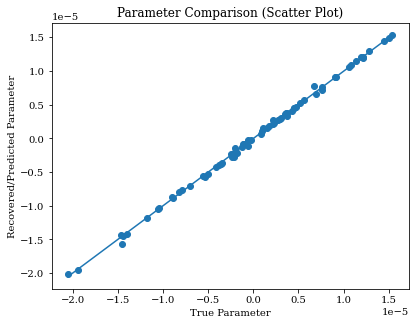

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays if they're JAX arrays
true_vals = np.array(true_params)
pred_vals = np.array(best_params)

plt.figure()
plt.scatter(true_vals, pred_vals)

# Add a diagonal line for reference
xmin, xmax = true_vals.min(), true_vals.max()
ref_line = np.array([xmin, xmax])
plt.plot(ref_line, ref_line)

plt.xlabel("True Parameter")
plt.ylabel("Recovered/Predicted Parameter")
plt.title("Parameter Comparison (Scatter Plot)")
plt.savefig("predicted_vs_true_order_7.png")

plt.show()



In [ ]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.scipy.ndimage import map_coordinates
import optax
from tqdm import tqdm

###############################################################################
# 1) Create normalized coordinate grid [-1, +1] & build polynomial powers
###############################################################################
def create_image_coords(npix, pixel_scale):
    """
    Returns two arrays (grid_x, grid_y) each of shape (npix, npix),
    spanning [-1,1]. We IGNORE the 'pixel_scale' argument to ensure the
    polynomial domain remains small. This is critical for stable high-order fits.
    """
    coords_1d = jnp.linspace(-1.0, 1.0, npix)
    grid_x, grid_y = jnp.meshgrid(coords_1d, coords_1d, indexing="xy")
    return grid_x, grid_y

def get_polynomial_powers(order):
    """
    Returns a list of (p, q) for all terms x^p * y^q with p+q <= order.
    For order=7, that yields 36 terms: (0,0), (1,0), (0,1), (2,0), etc.
    """
    powers = []
    for n in range(order + 1):
        for p in range(n + 1):
            q = n - p
            powers.append((p, q))
    return powers

###############################################################################
# 2) Distortion function: warp coords via polynomial expansions
###############################################################################
def distort_coords(params, coords, powers):
    """
    params: shape (2*N,) where N = number of polynomial terms
      The first N are x-distortion coeffs, the last N are y-distortion coeffs.
    coords: (x_grid, y_grid) each shape (npix, npix) in [-1,+1].
    powers: list of (p,q) exponent pairs.

    Returns (x_dist, y_dist) same shape as coords.
    """
    x_grid, y_grid = coords
    n_terms = len(powers)
    px = params[:n_terms]   # x-distortion coeffs
    py = params[n_terms:]   # y-distortion coeffs

    shift_x = jnp.zeros_like(x_grid)
    shift_y = jnp.zeros_like(y_grid)

    for i, (p, q) in enumerate(powers):
        shift_x += px[i] * (x_grid ** p) * (y_grid ** q)
        shift_y += py[i] * (x_grid ** p) * (y_grid ** q)

    x_dist = x_grid + shift_x
    y_dist = y_grid + shift_y
    return x_dist, y_dist

###############################################################################
# 3) Sample an image at the distorted coords -> final "warped" image
###############################################################################
def sample_image_at_distorted_coords(image, params, coords, powers):
    """
    Given 'image', polynomial-distort its pixel coords, and sample via map_coordinates.

    coords are in [-1,+1]. We map them into [0..npix-1] for interpolation.
    """
    x_dist, y_dist = distort_coords(params, coords, powers)
    npix = image.shape[0]

    half = (npix - 1) / 2.0
    row_indices = half * (y_dist + 1.0)
    col_indices = half * (x_dist + 1.0)

    sample_coords = jnp.stack([row_indices, col_indices], axis=0)
    warped_image = map_coordinates(image, sample_coords, order=1, mode="nearest")
    return warped_image

###############################################################################
# 4) Build a sum-of-squares loss *with optional L2 regularization*
###############################################################################
def build_loss_fn(ideal_image, distorted_image, coords, powers, lam=0.0):
    """
    Returns a function that, given a param-vector, warps 'ideal_image'
    and compares to 'distorted_image' via SSE + lam * ||params||^2.

    'lam' is the regularization strength (0=off). Increase if you see overfitting.
    """
    def loss_fn(params):
        predicted = sample_image_at_distorted_coords(ideal_image, params, coords, powers)
        residuals = predicted - distorted_image
        sse = jnp.sum(residuals**2)
        reg = lam * jnp.sum(params**2)  # L2 penalty
        return sse + reg
    return loss_fn

###############################################################################
# 5) Fit function using ADAM, with learning rate & reg param
###############################################################################
def fit_polynomial_adam(
    ideal_image,
    distorted_image,
    coords,
    powers,
    learning_rate=1e-5,
    num_steps=5000,
    lam=0.0
):
    """
    Minimizes SSE + lam*||params||^2 between warped(ideal_image) and 'distorted_image'
    to recover polynomial-distortion params. Uses ADAM from Optax.

    - ideal_image, distorted_image: shape (npix, npix).
    - coords: (x_grid, y_grid) in [-1,+1].
    - powers: polynomial exponents from get_polynomial_powers().
    - learning_rate: e.g. 1e-5 for higher-order polynomials.
    - num_steps: how many gradient steps.
    - lam: L2 regularization strength, e.g. 1e-5 or 1e-6 to reduce overfitting.

    Checking every 100 steps if the loss goes up relative to best so far:
      - if yes, revert & break
      - if no, keep going

    Also storing the loss at EVERY step in 'loss_history', so it can be plotted later.
    """
    n_terms = len(powers)
    param_size = 2 * n_terms  # x-dist + y-dist
    params = jnp.zeros(param_size)  # start from zero

    # Build loss & grad
    loss_fn = build_loss_fn(ideal_image, distorted_image, coords, powers, lam=lam)
    grad_fn = grad(loss_fn)

    # Try a more robust scheduler with warm-up
    scheduler = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=5e-5,
    warmup_steps=500,
    decay_steps=4500,
    end_value=1e-6
    )
    optimizer = optax.adam(scheduler)

    opt_state = optimizer.init(params)

    # Track best so far
    best_params = params
    best_loss = float(loss_fn(params))

    # We'll store the per-iteration loss here
    loss_history = []

    for step in tqdm(range(num_steps)):
        g = grad_fn(params)
        updates, opt_state = optimizer.update(g, opt_state)
        params = optax.apply_updates(params, updates)

        # Evaluate the new loss at EVERY iteration
        current_loss = float(loss_fn(params))
        loss_history.append(current_loss)

        # Only check "stop if up" every 100 steps
        if step % 500 == 0 and step > 0:
            if current_loss > best_loss:
                # print(f"Loss increased at step {step}, reverting to previous params and stopping.")
                # params = best_params
                # break
                continue
            else:
                best_params = params
                best_loss = current_loss

        # Optional logging every 500 steps
        if step % 500 == 0:
            print(f"Step {step}, Loss={current_loss:.6e}")

    final_loss = float(loss_fn(params))
    return params, final_loss, loss_history

# Suppose you have:
N = 256
pixel_scale = 0.375
coords = create_image_coords(N, pixel_scale)

order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)

true_params = 1e-5 * jax.random.normal(key, shape=(2*n_terms,))
distorted_psf = sample_image_at_distorted_coords(psfs[0], true_params, coords, powers)

best_params_one, final_loss_one, loss_history_one = fit_polynomial_adam(
    psfs[0],
    distorted_psf,
    coords,
    powers,
    learning_rate=1e-6,
    num_steps=4500,
    lam=1e-5,
)

print("Recovered Params:", best_params_one)
print("Final Loss:", final_loss_one)

  0%|          | 1/4500 [00:00<07:31,  9.96it/s]

Step 0, Loss=1.032333e+03


 11%|█         | 502/4500 [00:42<05:51, 11.37it/s]

Step 500, Loss=7.330853e+01


 33%|███▎      | 1502/4500 [02:06<05:07,  9.76it/s]

Step 1500, Loss=1.409495e-01


 44%|████▍     | 2002/4500 [02:44<03:07, 13.33it/s]

Step 2000, Loss=7.684808e-02


 67%|██████▋   | 3002/4500 [04:04<01:52, 13.37it/s]

Step 3000, Loss=8.828732e-03


100%|██████████| 4500/4500 [06:00<00:00, 12.50it/s]

Recovered Params: [-2.83269230e-07  4.67431255e-06  2.95066729e-06  1.56339752e-06
 -1.27282760e-06  2.13930844e-06 -1.44980886e-05  7.64472497e-06
  5.21620541e-06  9.20863386e-06 -3.97671738e-06  1.15665352e-05
  1.43313746e-05  1.09200073e-05 -2.82678798e-07  9.40145856e-06
  5.70933707e-06  2.45947899e-06 -1.56088117e-05  7.26898452e-06
 -2.59696935e-06 -1.16709052e-05 -1.95717439e-05  3.64392076e-06
 -2.44216699e-06  1.22656875e-05 -1.40705461e-05 -5.66158224e-06
  2.47450362e-06  1.52779921e-05  6.74504599e-06 -7.72136389e-07
 -5.08451194e-06  7.85423526e-06  1.52910980e-06 -3.40648694e-06
  4.54897508e-06  2.27692931e-06 -5.57330213e-06 -8.83141274e-06
 -2.10949020e-06  3.08773861e-06 -2.02096953e-06  1.08956613e-06
  3.79972334e-06 -1.05056524e-05  4.58045179e-06  1.19307178e-05
  4.09549375e-06 -7.11670191e-06  1.86425655e-06 -1.45339618e-06
 -2.62261824e-06  1.30252256e-05  3.35485993e-06 -2.13870067e-06
 -2.70015903e-06 -4.23691608e-06  3.82019789e-06  1.20429941e-05
 -1.028

In [90]:
print("Recovered Params:", best_params_one)
print("Final Loss:", final_loss_one)

Recovered Params: [-2.82563434e-07  4.67347763e-06  2.95326481e-06  1.55495070e-06
 -1.26762484e-06  2.13923977e-06 -1.44368405e-05  7.64605466e-06
  5.20538288e-06  9.14101383e-06 -3.91564618e-06  1.15735029e-05
  1.44436726e-05  1.09538905e-05 -2.95677552e-07  9.13588428e-06
  5.66828339e-06  2.70193868e-06 -1.55955386e-05  7.19442414e-06
 -2.30656747e-06 -1.17348882e-05 -1.96009314e-05  3.57382805e-06
 -2.47558796e-06  1.21616640e-05 -1.41174978e-05 -5.65127766e-06
  2.70130386e-06  1.53241817e-05  6.62061893e-06 -7.96728386e-07
 -5.28221244e-06  7.83968517e-06  1.61574269e-06 -3.66872905e-06
  4.54924566e-06  2.28557224e-06 -5.57410976e-06 -8.84349447e-06
 -2.11139081e-06  3.08602512e-06 -2.02419233e-06  1.10513884e-06
  3.80822576e-06 -1.05010886e-05  4.59475359e-06  1.19525330e-05
  4.06680601e-06 -7.12205338e-06  1.92262792e-06 -1.37288703e-06
 -2.70372493e-06  1.29743985e-05  3.36825792e-06 -2.22815811e-06
 -2.76428955e-06 -4.22375615e-06  3.80739789e-06  1.20318964e-05
 -1.026

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.ndimage import map_coordinates
import jax.lax as lax
import optax
from tqdm.auto import trange, tqdm

###############################################################################
# 1) Create normalized coordinate grid [-1, +1] & build polynomial powers
###############################################################################
def create_image_coords(npix, pixel_scale):
    """
    Returns two arrays (grid_x, grid_y) each of shape (npix, npix),
    spanning [-1,1]. (pixel_scale is ignored to keep the coordinate domain small.)
    """
    coords_1d = jnp.linspace(-1.0, 1.0, npix)
    grid_x, grid_y = jnp.meshgrid(coords_1d, coords_1d, indexing="xy")
    return grid_x, grid_y

def get_polynomial_powers(order):
    """
    Returns a list of (p, q) pairs for all terms x^p * y^q with p+q <= order.
    For order=7, that yields 36 terms.
    """
    powers = []
    for n in range(order + 1):
        for p in range(n + 1):
            q = n - p
            powers.append((p, q))
    return powers

###############################################################################
# 2) Distortion function: warp coordinates via polynomial expansions
###############################################################################
def distort_coords(params, coords, powers):
    """
    Applies a polynomial distortion to the given coordinates.
    
    params: array of shape (2*N,), where the first N elements are the x-distortion
            coefficients and the last N are the y-distortion coefficients.
    coords: tuple (x_grid, y_grid), each of shape (npix, npix) in [-1, 1].
    powers: list of (p, q) exponent pairs.
    
    Returns:
      (x_dist, y_dist) = distorted coordinates (each shape (npix, npix)).
    """
    x_grid, y_grid = coords
    n_terms = len(powers)
    px = params[:n_terms]
    py = params[n_terms:]
    
    shift_x = jnp.zeros_like(x_grid)
    shift_y = jnp.zeros_like(y_grid)
    
    for i, (p, q) in enumerate(powers):
        shift_x += px[i] * (x_grid ** p) * (y_grid ** q)
        shift_y += py[i] * (x_grid ** p) * (y_grid ** q)
    
    return x_grid + shift_x, y_grid + shift_y

###############################################################################
# 3) Sample an image at the distorted coordinates -> final "warped" image
###############################################################################
def sample_image_at_distorted_coords(image, params, coords, powers):
    """
    Given an image, applies the polynomial distortion to its coordinate grid
    and samples a warped version via map_coordinates.
    
    The input grid (in [-1, 1]) is mapped into pixel indices [0, npix-1].
    """
    x_dist, y_dist = distort_coords(params, coords, powers)
    npix = image.shape[0]
    half = (npix - 1) / 2.0
    row_indices = half * (y_dist + 1.0)
    col_indices = half * (x_dist + 1.0)
    sample_coords = jnp.stack([row_indices, col_indices], axis=0)
    return map_coordinates(image, sample_coords, order=1, mode="nearest")

###############################################################################
# 4) Build chi-squared loss function over multiple PSFs (vectorized)
###############################################################################
def build_loss_fn(ideal_images, distorted_images, coords, powers, read_noise_var=0.0, epsilon=1e-14):
    """
    Returns a chi-squared loss function over a batch of ideal and distorted images.
    
    The loss is computed as:
       loss = sum((residual^2) / (predicted + read_noise_var + epsilon))
       
    ideal_images, distorted_images: arrays of shape (B, npix, npix)
    coords: (x_grid, y_grid) in [-1, 1]
    powers: polynomial exponent pairs
    read_noise_var: additional read noise variance (set to 0 if not used)
    epsilon: a small constant to avoid division by zero.
    """
    def loss_fn(params):
        predicted = vmap(lambda img: sample_image_at_distorted_coords(img, params, coords, powers))(ideal_images)
        residuals = predicted - distorted_images
        # Estimate variance per pixel (using model prediction as proxy for Poisson variance)
        error = np.sqrt(distorted_images)
        #variance = predicted
        chi2_loss = jnp.sum((residuals ** 2) / (error**2 + epsilon))
        return chi2_loss
    return loss_fn

###############################################################################
# 5) Fit function using ADAM with a warmup-cosine decay schedule and parameter averaging
###############################################################################
def fit_polynomial_adam(ideal_images, distorted_images, coords, powers,
                        learning_rate=1e-5, num_steps=5000, avg_window=100, true_params=None):
    """
    Recovers the polynomial distortion parameters by minimizing the chi-squared loss over all
    image pairs using ADAM with a warmup-cosine decay learning rate schedule, and averages 
    the last avg_window parameter vectors.
    
    If true_params is provided, computes the mismatch (sum of absolute differences)
    for each final parameter vector, then returns the mean and std of that mismatch.
    
    Returns:
      (params_avg, final_loss_avg, loss_history, mismatch_mean, mismatch_std, final_params_arr)
    """
    loss_fn = build_loss_fn(ideal_images, distorted_images, coords, powers)
    grad_fn = jit(grad(loss_fn))

    n_terms = len(powers)
    param_size = 2 * n_terms
    params = jnp.zeros(param_size)

    # Learning rate schedule: warmup to learning_rate over 500 steps, then cosine decay to 10% of learning_rate.
    scheduler = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=learning_rate,
        warmup_steps=500,
        decay_steps=num_steps - 500,
        end_value=learning_rate * 0.1
    )
    optimizer = optax.adam(scheduler)
    opt_state = optimizer.init(params)

    loss_history = []
    final_params_history = []
    final_loss_history = []

    @jit
    def update(params, opt_state):
        grads = grad_fn(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state

    params_list = []
    for step in tqdm(range(num_steps), desc="Fitting", position=1, leave=True):
        params, opt_state = update(params, opt_state)
        params_list.append(params)
        current_loss = loss_fn(params)
        loss_history.append(current_loss)
        if step >= num_steps - avg_window:
            final_params_history.append(params)
            final_loss_history.append(current_loss)
        if step % 500 == 0:
            print(f"Step {step}, Loss={float(current_loss):.6e}")
        


    final_params_arr = jnp.stack(final_params_history, axis=0)
    final_loss_arr = jnp.array(final_loss_history)
    params_avg = jnp.mean(final_params_arr, axis=0)
    final_loss_avg = float(jnp.mean(final_loss_arr))

    mismatch_mean, mismatch_std = None, None
    if true_params is not None:
        mismatch_list = []
        for pvec in final_params_arr:
            diff = jnp.abs(pvec - true_params)
            mismatch = jnp.sum(diff)
            mismatch_list.append(mismatch)
        mismatch_arr = jnp.array(mismatch_list)
        mismatch_mean = float(jnp.mean(mismatch_arr))
        mismatch_std = float(jnp.std(mismatch_arr))
    


    return params_avg, final_loss_avg, loss_history, mismatch_mean, mismatch_std, final_params_arr, params_list
# for offset in dither_offsets:
#     source = dlT.AlphaCen(
#     n_wavels=3,
#     separation=10.0,
#     position_angle=90,
#     x_position=offset[0],
#     y_position=offset[1],
#     log_flux=6.832,
#     contrast=3.37,
#     bandpass=(530, 640),
#     weights=None
#     )
#     instrument = dlT.Toliman(optics, source)

#     psf = instrument.model()
#     psfs.append(psf)
# print(len(psfs))
# distorted_psfs = []
# for psf in psfs:
#     distorted_psf = sample_image_at_distorted_coords(psf, true_params, coords, powers)
#     distorted_psfs.append(distorted_psf)
# ideal_images = jnp.stack(psfs)
# distorted_images = jnp.stack(distorted_psfs)

# best_params_25, final_loss_25, loss_history_25 = fit_polynomial_adam(
#     ideal_images,
#     distorted_images,
#     coords,
#     powers,
#     learning_rate=1e-5,
#     num_steps=4000,
#     lam=0.0
# )
# -------------------------------
# Example usage:
# Assume you already have 5 ideal PSFs in 'psfs' and 5 corresponding distorted PSFs in 'distorted_psfs'.
# They should each be arrays of shape (256, 256).
#
# For example, if psfs and distorted_psfs are Python lists:
# ideal_images = jnp.stack(psfs)             # shape (5, 256, 256)
# distorted_images = jnp.stack(distorted_psfs) # shape (5, 256, 256)
#
# # Then:
# N = 256
# pixel_scale = 0.375
# coords = create_image_coords(N, pixel_scale)
# order = 7
# powers = get_polynomial_powers(order)
# n_terms = len(powers)
# distorted_psfs = []
# for psf in psfs:
#     distorted_psf = sample_image_at_distorted_coords(psf, true_params, coords, powers)
#     distorted_psfs.append(distorted_psf)
# ideal_images = jnp.stack(psfs)
# distorted_images = jnp.stack(distorted_psfs)
# true_params = 1e-5 * jax.random.normal(jax.random.PRNGKey(0), shape=(2*n_terms,))

# # Here, we call the fitting routine (adjust learning_rate and num_steps as needed)
# best_params, final_loss, loss_history = fit_polynomial_adam(
#     ideal_images,        # shape (5, 256, 256)
#     distorted_images,    # shape (5, 256, 256)
#     coords,
#     powers,
#     learning_rate=2e-6,
#     num_steps=4500,
#     lam=0.0              # No regularization in this version
# )

# print("Recovered Params:", best_params)
# print("Final Loss:", final_loss)


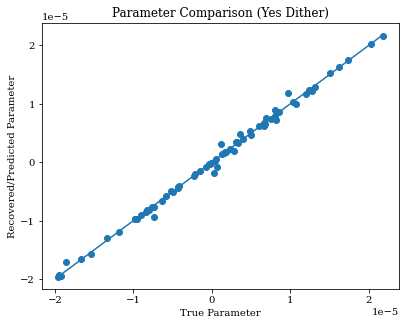

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays if they're JAX arrays
true_vals = np.array(true_params)
pred_vals = np.array(best_params_25)

plt.figure()
plt.scatter(true_vals, pred_vals)

# Add a diagonal line for reference
xmin, xmax = true_vals.min(), true_vals.max()
ref_line = np.array([xmin, xmax])
plt.plot(ref_line, ref_line)

plt.xlabel("True Parameter")
plt.ylabel("Recovered/Predicted Parameter")
plt.title("Parameter Comparison (Yes Dither)")
#plt.savefig("predicted_vs_true_order_7_dither.png")

plt.show()

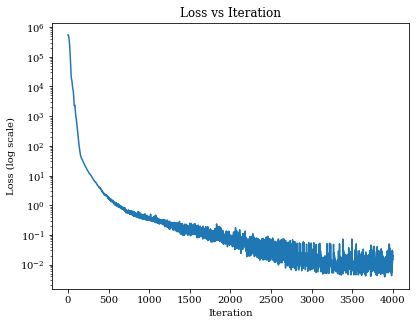

In [ ]:
plt.figure()
plt.semilogy(loss_history[0])
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iteration")
#plt.savefig("no_dither_loss_order_7.png")
plt.show()

Outer Loop (Dither Count):   0%|          | 0/2 [00:00<?, ?it/s]

Number of PSFs for dither count 1: 1


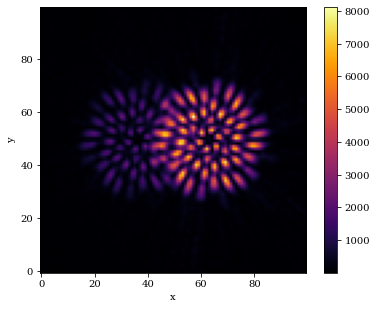

Fitting:   0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
###############################################################################
# 6) Helper: Get dither offsets with a specified count (random, with center included)
###############################################################################
def get_dither_offsets_random(k, scale, r_factor=1.0, key=None):
    """
    Returns exactly k dither offsets (as a jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are randomly placed around the origin,
    uniformly in both x and y, scaled by (scale * r_factor).
    
    Parameters:
      k (int): Total number of offsets (must be odd, e.g., 5, 7, 9, ..., 25).
      scale (float): Basic scale factor (e.g., detector pixel size in radians).
      r_factor (float): Multiplier for the spread.
      key (PRNGKey): A JAX random key. If None, defaults to jax.random.PRNGKey(0).
    
    Returns:
      jnp.array: Offsets of shape (k, 2).
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jax.random.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    # Generate k-1 random offsets uniformly within [-scale*r_factor, scale*r_factor] in both dimensions.
    random_offsets = jax.random.uniform(key, shape=(k - 1, 2), minval=-scale * r_factor, maxval=scale * r_factor)
    # Add the center offset [0, 0].
    offsets = jnp.concatenate([jnp.zeros((1, 2)), random_offsets], axis=0)
    return offsets

def get_dither_offsets_random_only_x(k, scale, r_factor=1.0, key=None):
    """
    Returns exactly k dither offsets (jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are randomly placed along the x-axis,
    uniformly in the range [-scale * r_factor, scale * r_factor], with y fixed at 0.
    
    Parameters:
      k (int): Total number of offsets (must be odd, e.g., 5, 7, 9, ..., 25).
      scale (float): Basic scale factor (e.g., detector pixel size in radians).
      r_factor (float): Multiplier that sets the spread.
      key (PRNGKey): JAX random key. If None, a default key (PRNGKey(0)) is used.
    
    Returns:
      jnp.array: Offsets of shape (k, 2), with y-component always zero.
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jax.random.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    # Only dither in x-direction; y is always 0
    x_offsets = jax.random.uniform(key, shape=(k - 1, 1), minval=-scale * r_factor, maxval=scale * r_factor)
    y_offsets = jnp.zeros_like(x_offsets)
    random_offsets = jnp.concatenate([x_offsets, y_offsets], axis=1)

    # Include the central offset [0, 0]
    offsets = jnp.concatenate([jnp.zeros((1, 2)), random_offsets], axis=0)
    return offsets

def get_dither_offsets_random_only_y(k, scale, r_factor=1.0, key=None):
    """
    Returns exactly k dither offsets (jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are randomly placed along the y-axis,
    uniformly in the range [-scale * r_factor, scale * r_factor], with the x-component fixed at 0.
    
    Parameters:
      k (int): Total number of offsets (must be odd, e.g., 5, 7, 9, ..., 25).
      scale (float): Basic scale factor (e.g., detector pixel size in radians).
      r_factor (float): Multiplier that sets the spread.
      key (PRNGKey): JAX random key. If None, defaults to jax.random.PRNGKey(0).
    
    Returns:
      jnp.array: Offsets of shape (k, 2), with x-component always zero.
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jax.random.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    # Only dither in the y direction: generate random y offsets and fix x to 0.
    y_offsets = jax.random.uniform(key, shape=(k - 1, 1),
                                   minval=-scale * r_factor,
                                   maxval= scale * r_factor)
    x_offsets = jnp.zeros_like(y_offsets)
    random_offsets = jnp.concatenate([x_offsets, y_offsets], axis=1)
    
    # Include the central offset [0, 0]
    offsets = jnp.concatenate([jnp.zeros((1, 2)), random_offsets], axis=0)
    return offsets



def get_dither_offsets_uniform(k, scale, r_factor=1.0):
    """
    Returns exactly k dither offsets (as a jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are evenly distributed on a circle.
    
    Parameters:
      k (int): The total number of offsets (must be odd, e.g., 5, 7, 9, ..., 25).
      scale (float): The basic scale factor (e.g., detector pixel size).
      r_factor (float): A multiplier that sets the radius of the circle for the nonzero offsets.
    
    Returns:
      jnp.array: An array of shape (k, 2) containing the dither offsets.
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    # If k==1, just return the center offset.
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    m = k - 1  # Number of offsets on the circle.
    angles = jnp.linspace(0, 2 * jnp.pi, m, endpoint=False)
    # Compute the circle offsets: (cos(theta), sin(theta)) scaled appropriately.
    circle_offsets = jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)
    circle_offsets = r_factor * scale * circle_offsets
    # Combine the center [0, 0] with the circle offsets.
    offsets = jnp.concatenate([jnp.zeros((1, 2)), circle_offsets], axis=0)
    return offsets

###############################################################################
# 7) Compute parameter loss (for analysis only)
###############################################################################
def compute_parameter_loss(true_params, predicted_params):
    """
    Computes both the sum-of-squared differences and sum-of-absolute differences
    between the true and predicted distortion parameters.
    """
    squared_loss = jnp.sum((true_params - predicted_params) ** 2)
    absolute_loss = jnp.sum(jnp.abs(true_params - predicted_params))
    return squared_loss, absolute_loss

###############################################################################
# Example usage:
# (Assumes you have 5 ideal PSFs stored in a list 'psfs' and your instrument setup (dlT.Toliman, dlT.AlphaCen, optics, etc.) is defined.)
###############################################################################
N = 100
pixel_scale = 0.375
coords = create_image_coords(N, pixel_scale)
order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)
# Convert pixel scale from arcsec to radians for dithering.
det_pixsize = dlu.arcsec2rad(pixel_scale)
true_params = 1e-5 * jax.random.normal(jax.random.PRNGKey(0), shape=(2*n_terms,))

# For each desired dither count (odd numbers from 1 to 25)
best_params_list = []
final_loss_list = []
loss_history_list = []
parameter_squared_loss_list = []
parameter_absolute_loss_list = []
mismatch_mean_list = []
mismatch_std_list = []
final_params_list = []

# key = jax.random.PRNGKey(713)
key = jax.random.PRNGKey(11)

for k in tqdm(range(1, 4, 2), desc="Outer Loop (Dither Count)", position=0):
    dither_offsets = get_dither_offsets_random(k, det_pixsize, r_factor=np.sqrt(3), key=key)
    psfs = []
    for offset in dither_offsets:
        source = dlT.AlphaCen(
            n_wavels=3,
            separation=10.0,
            position_angle=90,
            x_position=offset[0],
            y_position=offset[1],
            log_flux=7.832,
            contrast=3.37,
            bandpass=(530, 640),
            weights=None
        )
        instrument = dlT.Toliman(optics, source)
        psf = instrument.model()
        psfs.append(psf)
        #plt.imshow(psf[int(psf_npixels/2 - 30): int(psf_npixels/2 + 30), int(psf_npixels/2 - 30): int(psf_npixels/2 + 30)])
        #psf_smaller = psf[int(psf_npixels/2 - 30): int(psf_npixels/2 + 30), int(psf_npixels/2 - 30): int(psf_npixels/2 + 30)]
        #psfs.append(psf_smaller)
    print(f"Number of PSFs for dither count {k}: {len(psfs)}")
    
    distorted_psfs = [sample_image_at_distorted_coords(psf, true_params, coords, powers) for psf in psfs]
    #distorted_psfs = [sample_image_at_distorted_coords(psf_smaller, true_params, coords, powers) for psf_smaller in psfs]
    distorted_psfs_data = []
    for i, distorted_psf in enumerate(distorted_psfs):
        # photon_stdev = np.sqrt(distorted_psf)
        # readout_stdev = 5
        # #stdev = photon_stdev
        # stdev = np.sqrt(photon_stdev ** 2 + readout_stdev ** 2)
        noisy = jax.random.poisson(jr.key(i), lam=distorted_psf)
        #noisy = stdev * jr.normal(jr.key(i), shape = distorted_psf.shape)
        distorted_psfs_data.append(noisy)
    
    #plt.imshow(distorted_psfs_data[0] - distorted_psfs[0])
    plt.imshow(distorted_psfs_data[0])
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.title("Residual - Noisy Distorted PSF Minus Distorted PSF")
    plt.colorbar()
    plt.show()
    
    ideal_images = jnp.stack(psfs)
    distorted_images = jnp.stack(distorted_psfs_data)
    
    params, final_loss, loss_history, mismatch_mean, mismatch_std, final_params_arr, params_list = fit_polynomial_adam(
        ideal_images,
        distorted_images,
        coords,
        powers,
        learning_rate=1e-5,
        num_steps=1001,
        avg_window=300,
        true_params = true_params
    )
    
    best_params_list.append(params)
    final_loss_list.append(final_loss)
    loss_history_list.append(loss_history)
    mismatch_mean_list.append(mismatch_mean)
    mismatch_std_list.append(mismatch_std)
    sq_loss, abs_loss = compute_parameter_loss(true_params, params)
    parameter_squared_loss_list.append(sq_loss)
    parameter_absolute_loss_list.append(abs_loss)
    final_params_list.append(final_params_arr)

# print("Recovered Parameters Loss for different dither counts:")
# for idx, k in enumerate(range(1, 26, 2)):
#     print(f"Dither count = {k}, Param Squared Loss = {parameter_squared_loss_list[idx]:.6e}, Param Absolute Loss = {parameter_absolute_loss_list[idx]:.6e}")

# Step 0, Loss=1.971882e+05
# Step 500, Loss=1.961625e+05
# Step 1000, Loss=1.961461e+05
# Step 1500, Loss=1.961377e+05
# Step 2000, Loss=1.961360e+05
# Step 2500, Loss=1.961353e+05
# Step 3000, Loss=1.961302e+05
# Step 3500, Loss=1.961298e+05

In [364]:
print("Index |        True Param        |     Predicted Param")
print("------|--------------------------|----------------------")
for i in range(len(true_params)):
    print(f"{i:4d}  |  {float(true_params[i]):+12.6e}  |  {float(best_params_list[-1][i]):+12.6e}")


Index |        True Param        |     Predicted Param
------|--------------------------|----------------------
   0  |  +1.622642e-05  |  +1.622657e-05
   1  |  +2.025265e-05  |  +2.025287e-05
   2  |  -4.335944e-06  |  -4.335778e-06
   3  |  -7.861735e-07  |  -7.863810e-07
   4  |  +1.760909e-06  |  +1.761085e-06
   5  |  -9.720892e-06  |  -9.721625e-06
   6  |  -4.952987e-06  |  -4.952909e-06
   7  |  +4.943786e-06  |  +4.943547e-06
   8  |  +6.643493e-06  |  +6.643384e-06
   9  |  -9.501635e-06  |  -9.502034e-06
  10  |  +2.179530e-05  |  +2.179477e-05
  11  |  -1.955151e-05  |  -1.955161e-05


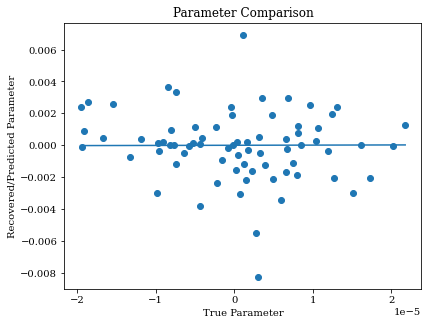

9948.7158203125


In [380]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays if they're JAX arrays
true_vals = np.array(true_params)
pred_vals = np.array(best_params_list[0])

plt.figure()
plt.scatter(true_vals, pred_vals)

# Add a diagonal line for reference
xmin, xmax = true_vals.min(), true_vals.max()
ref_line = np.array([xmin, xmax])
plt.plot(ref_line, ref_line)

plt.xlabel("True Parameter")
plt.ylabel("Recovered/Predicted Parameter")
plt.title("Parameter Comparison")
#plt.savefig("predicted_vs_true_order_7_new.png")

plt.show()

print(final_loss_list[0])

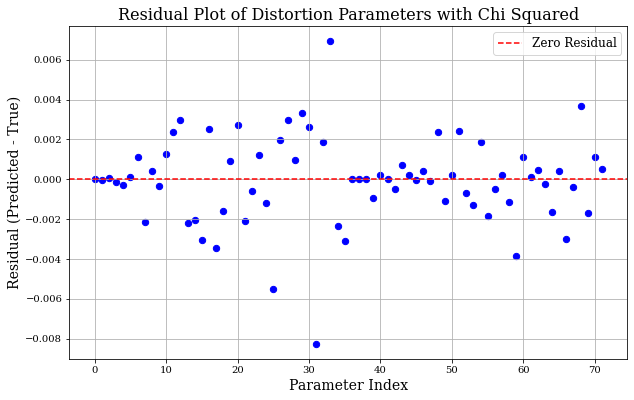

In [381]:
import matplotlib.pyplot as plt
import numpy as np

# Convert JAX arrays to NumPy arrays (if needed)
true_vals = np.array(true_params)          # True parameter values
pred_vals = np.array(best_params_list[-1])  # Use the best parameters from your last (or chosen) dither case

# Compute the residuals (difference between predicted and true parameters)
residuals = pred_vals - true_vals

# Option 1: Plot residuals against parameter index
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(true_vals)), residuals, color='blue', s=40)
plt.axhline(0, color='red', linestyle='--', label="Zero Residual")
plt.xlabel("Parameter Index", fontsize=14)
plt.ylabel("Residual (Predicted - True)", fontsize=14)
plt.title("Residual Plot of Distortion Parameters with Chi Squared", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
#plt.savefig("residual_vs_param_index_order_7_1e-5_new.png")
plt.show()


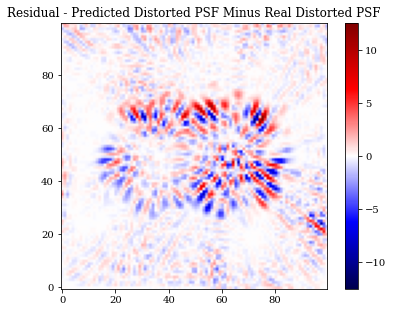

In [382]:
heyx_0 = sample_image_at_distorted_coords(psfs[0], best_params_list[0], coords, powers)
# heyx_1 = sample_image_at_distorted_coords(psfs[1], best_params_list[0], coords, powers)
# heyx_2 = sample_image_at_distorted_coords(psfs[2], best_params_list[0], coords, powers)

import matplotlib as mpl

# plt.imshow((heyx_0 - distorted_psfs[0])[90:164, 90:164], norm=mpl.colors.CenteredNorm(), cmap="seismic")
plt.imshow((heyx_0 - distorted_psfs[0]), norm=mpl.colors.CenteredNorm(), cmap="seismic")
#plt.imshow((psfs[0]-distorted_psfs[0])[90:164, 90:164], norm=mpl.colors.CenteredNorm(), cmap = "seismic")
plt.colorbar()
plt.title("Residual - Predicted Distorted PSF Minus Real Distorted PSF")
plt.show()
# plt.imshow((heyx_1 - distorted_psfs[1])[90:164, 90:164], norm=mpl.colors.CenteredNorm(), cmap="seismic")
# plt.colorbar()
# plt.title("First Random Dither")
# plt.show()
# plt.imshow((heyx_2 - distorted_psfs[2])[90:164, 90:164], norm=mpl.colors.CenteredNorm(), cmap="seismic")
# plt.colorbar()
# plt.title("Second Random Dither")
# plt.show()

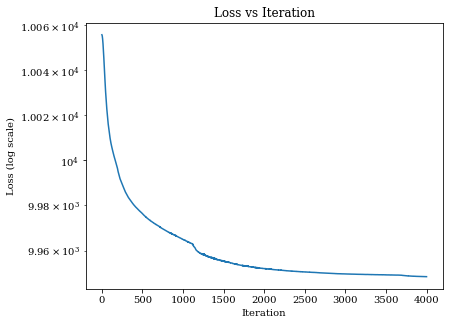

Text(0.5, 1.0, 'Parameter Values vs Iteration')

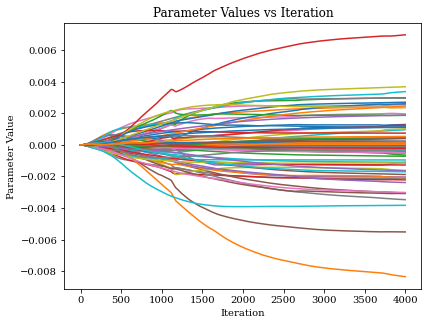

In [383]:
plt.figure()
plt.semilogy(loss_history_list[0])
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iteration")
#lt.savefig("25_dither_loss_order_7.png")
plt.show()

# plt.figure()
# for i in range(len(params_list)):
#     plt.plot(params_list[:, ][i])
#     plt.xlabel("Iteration")
#     plt.ylabel("Loss (log scale)")
#     plt.title("Loss vs Iteration (25 Random Dithers)")
    #plt.savefig("25_dither_loss_order_7.png")
# num_iterations = 4000
# for i in range(num_iterations):
#     plt.plot(np.arange(num_iterations), params_list[:, i], linewidth=1)

# plt.xlabel("Iteration (Final Averaging Window)", fontsize=14)
# plt.ylabel("Parameter Value", fontsize=14)
# plt.title("Convergence of Each Distortion Parameter", fontsize=16)
# plt.grid(True)
plt.plot(params_list)
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.title("Parameter Values vs Iteration")
# tot = 0
# for k in range(0, 13):
#     p = loss_history_list[k].index(np.min(loss_history_list[k]))
#     print(p)
#     tot = tot + p

# print(tot)
# print(tot / len(loss_history_list))


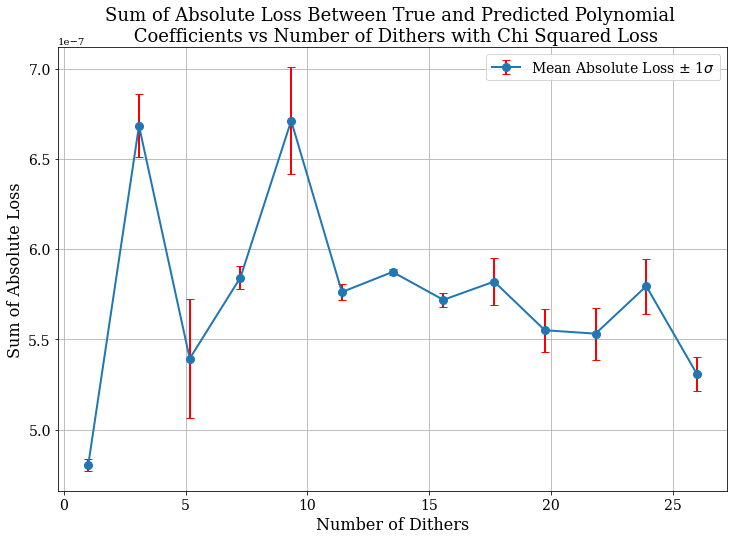

In [193]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, 26, 13)
plt.figure(figsize=(12, 8))  # Increase the figure size

plt.errorbar(
    x,
    mismatch_mean_list,
    yerr=mismatch_std_list,
    fmt='o-',              # 'o-' means circle markers connected by a line
    ecolor='red',          # error bar color
    capsize=4,             # length of the error bar caps
    linewidth=2,
    markersize=8
)

plt.xlabel("Number of Dithers", fontsize=16)
plt.ylabel("Sum of Absolute Loss", fontsize=16)
plt.title("Sum of Absolute Loss Between True and Predicted Polynomial \n Coefficients vs Number of Dithers with Chi Squared Loss", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Correct LaTeX-style legend
plt.legend([r"Mean Absolute Loss $\pm$ 1$\sigma$"], fontsize=14)

#plt.savefig("absolute_loss_order_seven_vs_dithers_random_with_error_new.png")
plt.show()


In [194]:
import pickle

data = {
    "best_params_list": best_params_list,
    "final_loss_list": final_loss_list,
    "loss_history_list": loss_history_list,
    "mismatch_mean_list": mismatch_mean_list,
    "mismatch_std_list": mismatch_std_list,
    "parameter_squared_loss_list": parameter_squared_loss_list,
    "parameter_absolute_loss_list": parameter_absolute_loss_list,
    "final_params_list": final_params_list,
}

with open("results_order_7_1e-5_dither_new_with_pixel_read_noise.pkl", "wb") as f:
    pickle.dump(data, f)


In [ ]:
with open("results_crop_40_order_7_3e-6.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Access like this:
heybbg = loaded_data["best_params_list"]
h

[Array([ 1.61074204e-05,  1.98388407e-05, -4.14665101e-06,  2.12909399e-07,
         1.65656820e-06, -8.51283312e-06, -1.55627947e-06,  4.34034428e-06,
         6.98290978e-06, -1.19935985e-05,  1.92998177e-05, -1.92546868e-05,
         2.09658742e-06,  1.62813171e-06,  9.90637182e-06,  8.05773834e-06,
         1.19271072e-05,  4.65285939e-06,  1.30150261e-06, -1.94142594e-05,
        -1.26790255e-05,  1.89589136e-05,  3.60646879e-07,  9.13476651e-06,
         1.10789370e-06,  3.70592829e-06,  1.24503749e-05,  8.73926274e-06,
        -3.81248356e-06, -9.14852899e-06, -1.42583131e-05,  2.31098011e-06,
         3.91700183e-08,  2.44620679e-07, -2.03547188e-06, -3.00337638e-06,
         8.53643905e-06, -8.08290497e-06, -5.39043938e-08, -1.51377355e-06,
        -8.63219702e-06, -7.36285574e-06,  2.37791846e-06,  7.37250184e-06,
        -4.45015360e-07, -6.42026862e-06, -4.05219180e-06, -1.99254173e-05,
         1.26725499e-05,  5.85395810e-06,  1.06719835e-06,  1.55162786e-06,
        -1.2

[[0. 0.]]


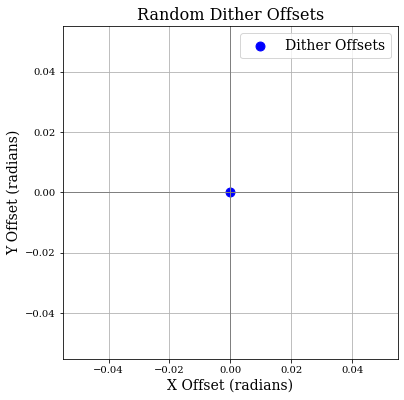

[[0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0898978e-07]
 [0.0000000e+00 2.4816941e-07]]


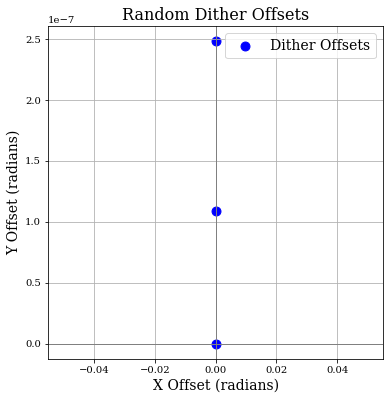

[[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0898978e-07]
 [ 0.0000000e+00  2.4816941e-07]
 [ 0.0000000e+00  1.0902884e-06]
 [ 0.0000000e+00 -8.0103365e-07]]


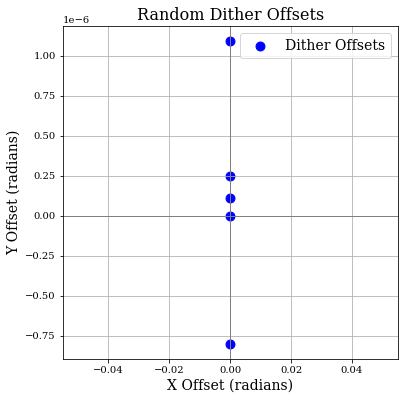

[[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0898978e-07]
 [ 0.0000000e+00  2.4816941e-07]
 [ 0.0000000e+00  1.0902884e-06]
 [ 0.0000000e+00 -8.0103365e-07]
 [ 0.0000000e+00 -1.5979400e-07]
 [ 0.0000000e+00 -1.5837074e-06]]


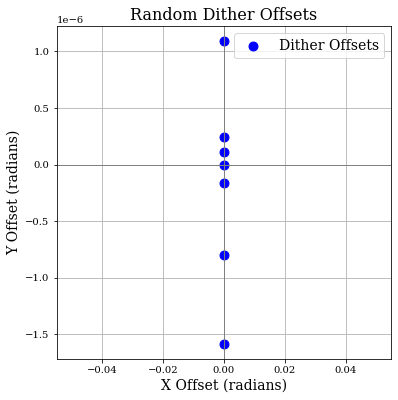

[[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0898978e-07]
 [ 0.0000000e+00  2.4816941e-07]
 [ 0.0000000e+00  1.0902884e-06]
 [ 0.0000000e+00 -8.0103365e-07]
 [ 0.0000000e+00 -1.5979400e-07]
 [ 0.0000000e+00 -1.5837074e-06]
 [ 0.0000000e+00  1.3667105e-06]
 [ 0.0000000e+00  3.7113514e-07]]


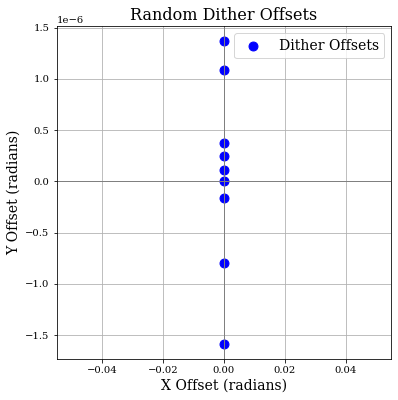

[[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0898978e-07]
 [ 0.0000000e+00  2.4816941e-07]
 [ 0.0000000e+00  1.0902884e-06]
 [ 0.0000000e+00 -8.0103365e-07]
 [ 0.0000000e+00 -1.5979400e-07]
 [ 0.0000000e+00 -1.5837074e-06]
 [ 0.0000000e+00  1.3667105e-06]
 [ 0.0000000e+00  3.7113514e-07]
 [ 0.0000000e+00 -6.5998627e-08]
 [ 0.0000000e+00 -5.0884188e-07]]


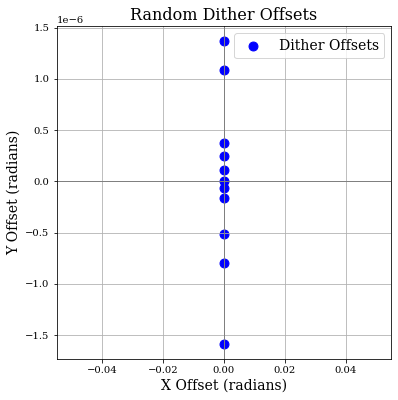

In [162]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Assuming your random dither function is defined as follows:
def get_dither_offsets_random(k, scale, r_factor=1.0, key=None):
    """
    Returns exactly k dither offsets (as a jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are randomly placed around the origin,
    uniformly in both x and y, scaled by (scale * r_factor).
    
    Parameters:
      k (int): Total number of offsets (must be odd, e.g., 5, 7, 9, ..., 25).
      scale (float): Basic scale factor (e.g., detector pixel size in radians).
      r_factor (float): Multiplier for the spread.
      key (PRNGKey): A JAX random key. If None, defaults to jax.random.PRNGKey(0).
    
    Returns:
      jnp.array: Offsets of shape (k, 2).
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jax.random.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    # Generate k-1 random offsets uniformly within [-scale*r_factor, scale*r_factor] in both dimensions.
    random_offsets = jax.random.uniform(key, shape=(k - 1, 2), minval=-scale * r_factor, maxval=scale * r_factor)
    # Add the center offset [0, 0].
    offsets = jnp.concatenate([jnp.zeros((1, 2)), random_offsets], axis=0)
    return offsets

def get_dither_offsets_random_only_y(k, scale, r_factor=1.0, key=None):
    """
    Returns exactly k dither offsets (jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are randomly placed along the y-axis,
    uniformly in the range [-scale * r_factor, scale * r_factor], with the x-component fixed at 0.
    
    Parameters:
      k (int): Total number of offsets (must be odd, e.g., 5, 7, 9, ..., 25).
      scale (float): Basic scale factor (e.g., detector pixel size in radians).
      r_factor (float): Multiplier that sets the spread.
      key (PRNGKey): JAX random key. If None, defaults to jax.random.PRNGKey(0).
    
    Returns:
      jnp.array: Offsets of shape (k, 2), with x-component always zero.
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jax.random.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    # Only dither in the y direction: generate random y offsets and fix x to 0.
    y_offsets = jax.random.uniform(key, shape=(k - 1, 1),
                                   minval=-scale * r_factor,
                                   maxval= scale * r_factor)
    x_offsets = jnp.zeros_like(y_offsets)
    random_offsets = jnp.concatenate([x_offsets, y_offsets], axis=1)
    
    # Include the central offset [0, 0]
    offsets = jnp.concatenate([jnp.zeros((1, 2)), random_offsets], axis=0)
    return offsets

# Example:
# Set your detector pixel size in radians.
# (For instance, if you already compute it as: det_pixsize = dlu.arcsec2rad(pixel_scale))
det_pixsize = dlu.arcsec2rad(0.375)  # For example purposes; replace with your actual value if available.

# Choose an odd number of dithers, e.g., 11.
key = jax.random.PRNGKey(43)
ks = [1, 3, 5, 7, 9, 11]
for k in ks:

# Create a key (you may split keys if necessary in your application).
  dither_offsets = get_dither_offsets_random_only_y(k, det_pixsize, r_factor=1.0, key=key)

  # Convert to a NumPy array for plotting.
  dither_offsets_np = jnp.asarray(dither_offsets)
  print(dither_offsets)
  plt.figure(figsize=(6, 6))
  plt.scatter(dither_offsets_np[:, 0], dither_offsets_np[:, 1], c='blue', s=80, label="Dither Offsets")
  plt.axhline(0, color='gray', lw=1)
  plt.axvline(0, color='gray', lw=1)
  plt.title("Random Dither Offsets", fontsize=16)
  plt.xlabel("X Offset (radians)", fontsize=14)
  plt.ylabel("Y Offset (radians)", fontsize=14)
  plt.legend(fontsize=14)
  plt.grid(True)
  #plt.savefig("random_dithers_location.png")
  plt.show()



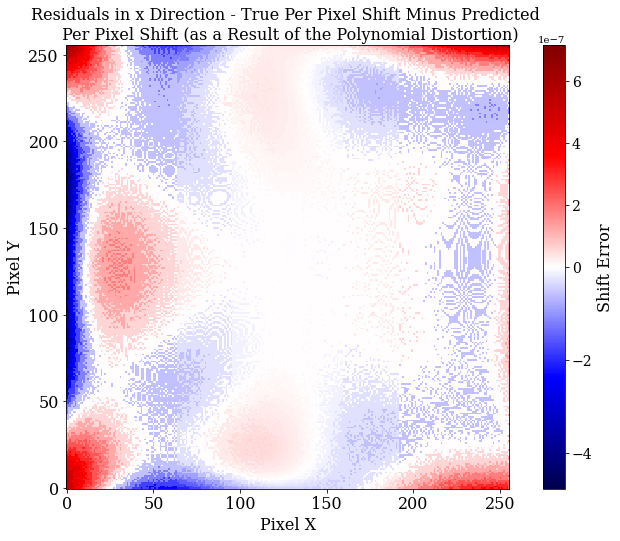

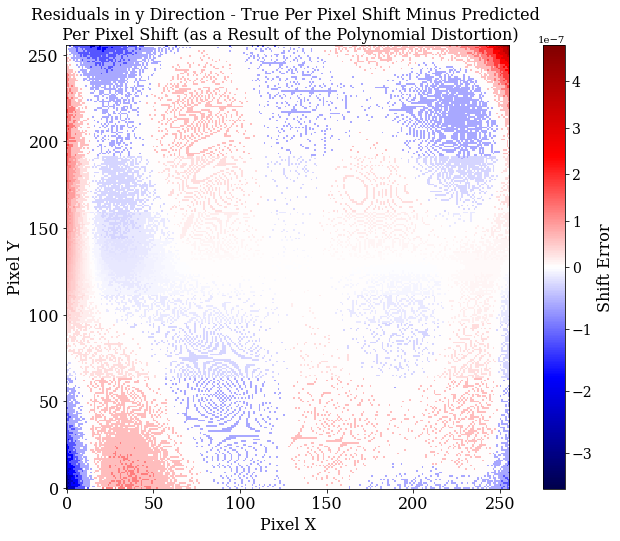

0.000115916366
3.5620295e-05


In [63]:
# Calculate the ideal coordinate grid.
coords = create_image_coords(N, pixel_scale)  # returns (x_grid, y_grid)

# Compute the distorted coordinates using the true polynomial coefficients.
true_distorted_coords = distort_coords(true_params, coords, powers)
# And compute the per-pixel true shifts (difference from the ideal grid).
true_x_shift = true_distorted_coords[0] - coords[0]
true_y_shift = true_distorted_coords[1] - coords[1]

# Compute the distorted coordinates using the recovered polynomial coefficients.
recovered_distorted_coords = distort_coords(best_params_list[0], coords, powers)
# And compute the per-pixel predicted shifts.
pred_x_shift = recovered_distorted_coords[0] - coords[0]
pred_y_shift = recovered_distorted_coords[1] - coords[1]

# Compute the difference between the true and predicted shift fields.
diff_x = true_x_shift - pred_x_shift
diff_y = true_y_shift - pred_y_shift

import matplotlib.colors as colors
vmin_x = diff_x.min()
vmax_x = diff_x.max()
norm_x = colors.TwoSlopeNorm(vmin=vmin_x, vcenter=0, vmax=vmax_x)

vmin_y = diff_y.min()
vmax_y = diff_y.max()
norm_y = colors.TwoSlopeNorm(vmin=vmin_y, vcenter=0, vmax=vmax_y)

plt.figure(figsize=(12, 8)) 
im = plt.imshow(diff_x, cmap="seismic", norm=norm_x, interpolation="nearest")
plt.title("Residuals in x Direction - True Per Pixel Shift Minus Predicted \n Per Pixel Shift (as a Result of the Polynomial Distortion)", fontsize=16)
plt.xlabel("Pixel X", fontsize=16)
plt.ylabel("Pixel Y", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Shift Error", fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()

plt.figure(figsize=(12, 8)) 
im = plt.imshow(diff_y, cmap="seismic", norm=norm_y, interpolation="nearest")
plt.title("Residuals in y Direction - True Per Pixel Shift Minus Predicted \n Per Pixel Shift (as a Result of the Polynomial Distortion)", fontsize=16)
plt.xlabel("Pixel X", fontsize=16)
plt.ylabel("Pixel Y", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Shift Error", fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()

x_loss = np.sum(diff_x)
y_loss = np.sum(diff_y)
print(x_loss)
print(y_loss)

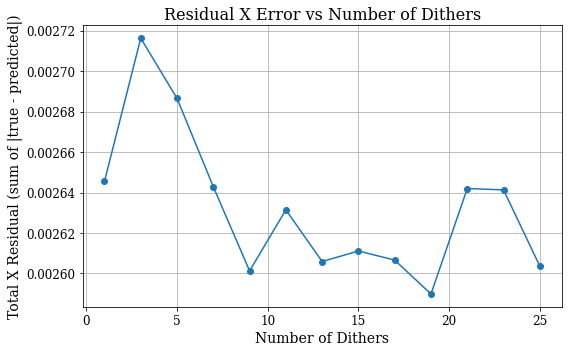

In [100]:
x_losses = []
# Calculate the ideal coordinate grid.

dither_counts = np.linspace(1, 25, 13)
coords = create_image_coords(N, pixel_scale)  # returns (x_grid, y_grid)

# Compute the distorted coordinates using the true polynomial coefficients.
true_distorted_coords = distort_coords(true_params, coords, powers)
# And compute the per-pixel true shifts (difference from the ideal grid).
true_x_shift = true_distorted_coords[0] - coords[0]
true_y_shift = true_distorted_coords[1] - coords[1]

for i in range(len(best_params_list)):
    # Distort coords using best_params_list[i]
    recovered_distorted_coords = distort_coords(best_params_list[i], coords, powers)
    pred_x_shift = recovered_distorted_coords[0] - coords[0]
    diff_x = true_x_shift - pred_x_shift
    x_loss = np.sum(np.abs(diff_x))  # or np.sum(diff_x**2) for squared loss
    x_losses.append(x_loss)

plt.figure(figsize=(8, 5))
plt.plot(dither_counts, x_losses, marker="o")
plt.xlabel("Number of Dithers", fontsize=14)
plt.ylabel("Total X Residual (sum of |true - predicted|)", fontsize=14)
plt.title("Residual X Error vs Number of Dithers", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("order_7_y_dither_residuals(x)_no_errorbars.png")
plt.show()


In [158]:
# Compute the true per-pixel x shift (using true_params, which is fixed).
true_distorted_coords = distort_coords(true_params, coords, powers)
true_x_shift = true_distorted_coords[0] - coords[0]

mean_xs = []
std_xs = []
# For each parameter vector in the final window, compute the x loss.
for param_array in tqdm(final_params_list, desc = "reee"):
    x_loss_list = []
    for pvec in param_array:
        recovered_coords = distort_coords(pvec, coords, powers)
        pred_x_shift = recovered_coords[0] - coords[0]
        diff_x = true_x_shift - pred_x_shift
        x_loss = jnp.sum(jnp.abs(diff_x))
        x_loss_list.append(x_loss)

    x_loss_arr = jnp.array(x_loss_list)
    mean_x_loss = float(jnp.mean(x_loss_arr))
    std_x_loss = float(jnp.std(x_loss_arr))
    mean_xs.append(mean_x_loss)
    std_xs.append(std_x_loss)

# Compute the true per-pixel x shift (using true_params, which is fixed).
# true_distorted_coords = distort_coords(true_params, coords, powers)
# true_y_shift = true_distorted_coords[1] - coords[1]

# mean_ys = []
# std_ys = []
# # For each parameter vector in the final window, compute the x loss.
# for param_array in tqdm(final_params_list, desc = "reee"):
#     y_loss_list = []
#     for pvec in param_array:
#         recovered_coords = distort_coords(pvec, coords, powers)
#         pred_y_shift = recovered_coords[1] - coords[1]
#         diff_y = true_y_shift - pred_y_shift
#         y_loss = jnp.sum(jnp.abs(diff_y))
#         y_loss_list.append(y_loss)

#     y_loss_arr = jnp.array(y_loss_list)
#     mean_y_loss = float(jnp.mean(y_loss_arr))
#     std_y_loss = float(jnp.std(y_loss_arr))
#     mean_ys.append(mean_y_loss)
#     std_ys.append(std_y_loss)




reee:   0%|          | 0/13 [00:00<?, ?it/s]

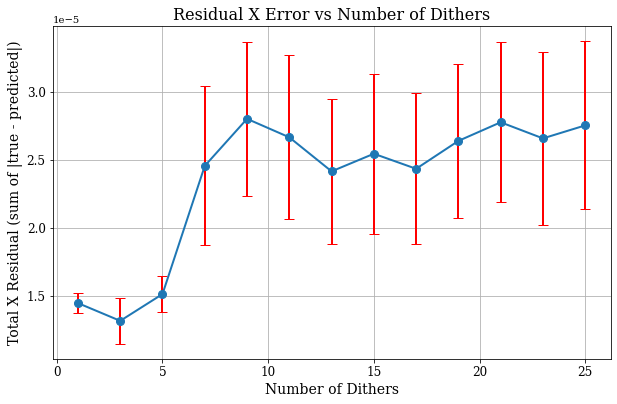

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose you have lists: dither_counts, mean_x_loss_list, std_x_loss_list
dither_counts = np.linspace(1, 25, 13) # for example

plt.figure(figsize=(10, 6))
plt.errorbar(
    dither_counts, 
    mean_xs,
    yerr=std_xs,
    fmt='o-', 
    ecolor='red', 
    capsize=5, 
    markersize=8, 
    linewidth=2
)
plt.xlabel("Number of Dithers", fontsize=14)
plt.ylabel("Total X Residual (sum of |true - predicted|)", fontsize=14)
plt.title("Residual X Error vs Number of Dithers", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
#plt.savefig("order_7_x_dither_residuals_yes_errorbars.png")
plt.show()

# plt.figure(figsize=(10, 6))
# plt.errorbar(
#     dither_counts, 
#     mean_ys,
#     yerr=std_ys,
#     fmt='o-', 
#     ecolor='red', 
#     capsize=5, 
#     markersize=8, 
#     linewidth=2
# )
# plt.xlabel("Number of Dithers", fontsize=14)
# plt.ylabel("Total Y Residual (sum of |true - predicted|)", fontsize=14)
# plt.title("Residual Y Error vs Number of Dithers", fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(True)
# #plt.savefig("order_7_y_dither_residuals_yes_errorbars.png")
# plt.show()



In [ ]:
# ────────────────────────────────────────────────────────────────
# Fit polynomial distortion while sweeping N_exposures
# and record residual statistics
# ────────────────────────────────────────────────────────────────
N              = 100
pixel_scale    = 0.375
coords         = create_image_coords(N, pixel_scale)
order          = 7
powers         = get_polynomial_powers(order)
n_terms        = len(powers)
det_pixsize    = dlu.arcsec2rad(pixel_scale)

true_params = 5e-5 * jax.random.normal(jax.random.PRNGKey(0),
                                       (2 * n_terms,))
key         = jax.random.PRNGKey(13)

N_list = [0, 1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]

# bookkeeping
best_params_list  = []
final_loss_list   = []
loss_history_list = []
mismatch_mean_list, mismatch_std_list = [], []
parameter_squared_loss_list, parameter_absolute_loss_list = [], []
final_params_list = []
per_exp_loss_history_list = []  # loss history per exposure

# diagnostics
resid_rms_list = []     # final residual RMS
shot_rms_list  = []     # expected shot-noise RMS
chi2_red_list  = []     # Louis's detectability χ²
chi2_postfit_list = [] 

read_noise_var = 0  # (σ_read = 5 e−) -- set to 0 if you want none
eps_floor      = 1e-8

for N_images in tqdm(N_list, desc="Outer Loop (N_images)", position=0):
    # 1) ideal PSF (one dither)
    dither_offsets = get_dither_offsets_random(
        1, det_pixsize, r_factor=jnp.sqrt(3), key=key
    )
    psfs = []
    for offset in dither_offsets:
        src = dlT.AlphaCen(
            n_wavels=3, separation=10.0, position_angle=90.0,
            x_position=offset[0], y_position=offset[1],
            log_flux=7.832, contrast=3.37,
            bandpass=(530, 640)
        )
        psfs.append(dlT.Toliman(optics, src).model())
    ideal_images = jnp.stack(psfs)                # (1, H, W)

    # 2) apply TRUE polynomial
    distorted_clean = jnp.stack([
        sample_image_at_distorted_coords(psf, true_params, coords, powers)
        for psf in ideal_images
    ])                                            # (1, H, W)

    # ── Detectability χ² : distorted_clean vs ideal_images ───────────
    lam      = distorted_clean # i.e. there is no noise here
    var_det  = lam / N_images + read_noise_var + eps_floor
    chi2_det = jnp.sum(((distorted_clean - ideal_images) ** 2) / var_det)
    dof      = int(np.prod(distorted_clean.shape))
    chi2_red = float(chi2_det / dof)
    chi2_red_list.append(chi2_red)
    print(f"N={N_images:7d} | reduced χ²(dist-vs-ideal) = {chi2_red:6.3f}")

    # 3) simulate N_images noisy exposures and average
    key, sub = jr.split(key)
    subkeys  = jr.split(sub, distorted_clean.shape[0])  # one key per PSF

    psf_sum = jnp.stack([
        jr.poisson(k, lam=img * N_images)
        for k, img in zip(subkeys, distorted_clean)
    ])                                                  # (1, H, W)
    distorted_images = (psf_sum / N_images).astype(jnp.float32)

    # ---------- initial loss (noise only) ----------
    resid_init  = distorted_images[0] - distorted_clean[0]
    var_init    = distorted_clean[0] / N_images + read_noise_var + eps_floor
    initial_loss = jnp.sum((resid_init ** 2) / var_init)
    print(f"            initial χ² = {float(initial_loss):.3e}")

    # 4) fit
    params, final_loss, loss_history, mm, ms, final_arr, params_list = \
        fit_polynomial_adam(
            ideal_images,
            distorted_images,
            coords,
            powers,
            learning_rate = 1e-5,
            num_steps     = 4000,
            avg_window    = 300,
            true_params   = true_params,
            n_images      = N_images,
            read_noise_var= read_noise_var,
            epsilon       = eps_floor
        )

    # ---------- residual RMS vs shot-noise ----------
    predicted_images = jnp.stack([
        sample_image_at_distorted_coords(psf, params, coords, powers)
        for psf in ideal_images
    ])
    resid      = predicted_images - distorted_images
    resid_rms  = float(jnp.sqrt(jnp.mean(resid ** 2)))
    mean_lambda= float(jnp.mean(distorted_clean))
    shot_rms   = np.sqrt(mean_lambda / N_images)

    resid_rms_list.append(resid_rms)
    shot_rms_list.append(shot_rms)

    
    var_fit = distorted_images / N_images + read_noise_var + eps_floor # here, distorted images has noise!
    dof     = int(np.prod(distorted_images.shape))

    chi2_post = jnp.sum(((predicted_images - distorted_images)**2) / var_fit) # before, we had noiseless distorted images
    # minus the ideal PSFs, now, predicted images minus noisy distorted images
    chi2_postfit = float(chi2_post / dof)
    chi2_postfit_list.append(chi2_postfit)

    # ---------- book-keeping ----------
    best_params_list.append(params)
    final_loss_list.append(final_loss)
    loss_history_list.append(loss_history)
    mismatch_mean_list.append(mm)
    mismatch_std_list.append(ms)
    sq, ab = compute_parameter_loss(true_params, params)
    parameter_squared_loss_list.append(sq)
    parameter_absolute_loss_list.append(ab)
    final_params_list.append(final_arr)
    per_exp_loss_history_list.append(
        [ float(l) / N_images for l in loss_history ]   # NEW
    )

# ────────────────────────────────────────────────────────────────
# Plot residual RMS vs shot-noise
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.loglog(N_list, shot_rms_list,  "o-", label="Expected shot-noise σ")
plt.loglog(N_list, resid_rms_list, "s-", label="Final residual RMS")
plt.xlabel("Number of exposures  $N$", fontsize=12)
plt.ylabel("RMS per pixel (counts)", fontsize=12)
plt.title("Residual RMS vs expected shot-noise", fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()

# ────────────────────────────────────────────────────────────────
# Plot reduced χ² to check detectability of distortion vs noise
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.semilogx(N_list, chi2_red_list, "o-")
plt.axhline(1.0, color="k", ls="--")
plt.xlabel("Number of exposures  $N$", fontsize=12)
plt.ylabel("Reduced χ² (distorted vs ideal)", fontsize=12)
plt.title("Is distortion detectable above shot-noise?", fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()

plt.figure(figsize=(8,5))
plt.semilogx(N_list, chi2_postfit_list, "o-", label="post-fit reduced χ²")
plt.axhline(1.0, color="k", ls="--", label="χ² = 1")
plt.xlabel("Number of exposures  $N$", fontsize=12)
plt.ylabel("Reduced χ² (model vs noisy data)", fontsize=12)
plt.title("Post-fit reduced χ² vs stack size", fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()